# Классификация изображений с эмоциями людей

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

print("TensorFlow Version:", tf.__version__)
print('GPU Device Found.' if tf.config.list_physical_devices('GPU') else 'GPU Device Not Found. Running on CPU')

TensorFlow Version: 2.8.3
GPU Device Not Found. Running on CPU


# <b>1. ПОДГОТОВКА ДАТАСЕТОВ</b>

## Подготовка файлов для работы с локального диска

### Загрузка данных на локальный диск

In [2]:
import gdown
import zipfile
from pathlib import Path

# Загрузка архива
# stable link https://drive.google.com/file/d/1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
ident = '1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg'
fname = 'emotions'

# Пусть к основной папке с изображениями
p = Path('./data')

# Путь к базовой директории, которая будет создана чуть позже
base_dir = p / fname

local_zip = gdown.download(id=ident, output = fname + '.zip')

Downloading...
From: https://drive.google.com/uc?id=1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
To: C:\Users\commi\YandexDisk\code_learning\DS_Sber\Профильный_модуль\SBER_Diploma\emotions.zip
100%|█████████████████████████████████████████████████████████████████████████████| 14.8M/14.8M [00:02<00:00, 5.33MB/s]


Распаковка в текущую директорию.

In [3]:
# Пусть к основной папке с изображениями
p = Path('./data')

# Путь к базовой директории, которая будет создана чуть позже
base_dir = p / fname

with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(p)

Переименуем папку с изображениями в `emotions`.

Для отключения ограничения "Только чтение" у папки с изображениями воспользуемся следующей функцией ([источник](https://www.tutorialspoint.com/How-to-change-the-permission-of-a-directory-using-Python#)):

In [4]:
def change_permissions_recursive(path, mode):
    for root, dirs, files in os.walk(path, topdown=False):
        for dr in [os.path.join(root,d) for d in dirs]:
            os.chmod(dr, mode)
        for file in [os.path.join(root, f) for f in files]:
                os.chmod(file, mode)

In [5]:
import os

zip_content = os.listdir(p)[0]
zip_content

'emotions_dataset'

Функция не всегда срабатывает с первого раза, поэтому запустим следующий цикл:

In [6]:
done = False

while done == False:
    try:
        change_permissions_recursive(p, 0o777)
        change_permissions_recursive(p / zip_content, 0o777)
        zip_content = os.renames(p / zip_content,
                   base_dir)
        done = True
    except:
        continue

Теперь загруженный архив можно удалить.

In [7]:
os.remove(fname + '.zip')

### Настройка директорий

Проверим содержимое папки с изображениями, мы должны увидеть список из папок с названиями этих папок и их количество. 

In [8]:
from pathlib import Path

# Базовая директория
base_dir = p / fname
# # base_dir = '/content/drive/MyDrive/Sber DS/Diploma/data/emotions/'  # for colab
classes = os.listdir(base_dir)

num_classes = len(classes)

# и ее содержимое
print("Содержимое базовой директории:")
print(classes)
print('Количество классов:', num_classes)

Содержимое базовой директории:
['ANGER', 'DISGUST', 'FEAR', 'JOYFULNESS', 'NEUTRAL']
Количество классов: 5


Переименуем папки в необходимые нам названия классов:

In [9]:
# class_names = [x.lower() for x in classes]
class_names = ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']

done = False
while done == False:
    try:
        change_permissions_recursive(base_dir, 0o777)
        done = True
    except:
        continue

done = False
while done == False:
    try:
        for i, class_name in enumerate(class_names):
            change_permissions_recursive(base_dir/class_name, 0o777)
            os.renames(base_dir/classes[i], base_dir/class_name)
        done = True
    except:
        continue

classes = os.listdir(base_dir)

In [10]:
classes

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']

### Удалим некорректные файлы

Если в архиве содержатся некорректные ("битые") файлы, то мы получим ошибку на том или ином этапе обучения и подготовки модели к переносу на мобильное устройство. Код ниже позволяет обнаружить и сразу удалить такие файлы при их наличии. Запустим эту функцию для всех папок с классами ([источник кода](https://github.com/tensorflow/datasets/issues/2188)).

In [11]:
from pathlib import Path
from tensorflow.io import read_file
from tensorflow.image import decode_image

def delete_corrupted_files(folder, base_dir):
    for image in sorted((base_dir / f'{folder}').glob('*')):
        try:
            img = read_file(str(image))
            img = decode_image(img)

            if img.ndim != 3:
                print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
                image.unlink()

        except Exception as e:
            print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
            image.unlink()

In [12]:
for folder in classes:
    print(folder)
    delete_corrupted_files(folder, base_dir)

anger
disgust
[ERR] data\emotions\disgust\5a971597aae6052a008b45a7.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] data\emotions\disgust\gettyimages-520925691.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] data\emotions\disgust\Universal_Expression_Disgust.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
fear
joyfulness
neutral


Битых файлов нет, можно двигаться дальше.

Сохраним пути к субдиректориям с классами в отдельные переменные и посмотрим на конечное количество изображений в каждом классе.

In [13]:
anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir = [base_dir / classes[i]
                                                   for i in range(len(classes))]
directories = anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir


anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames = [os.listdir(i)
                                                              for i in directories]
files_names = anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames


for i, cls_name in enumerate(class_names):
    print(cls_name + ':', len(files_names[i]))

anger: 174
disgust: 292
fear: 177
joyfulness: 339
neutral: 398


In [14]:
import seaborn as sns

x = np.array([len(anger_fnames), len(disgust_fnames),
              len(fear_fnames), len(joyfulness_fnames),
              len(neutral_fnames)])

plt.title('Распределение количества изображений по классам')
plt.pie(x, labels=classes, autopct='%.1f%%');

Классы несбалансированы, поэтому, помимо метрики `accuracy`, для оценки ошибки классификации мы будем использовать матрицу ошибок. 

Посмотрим на названия отдельных файлов.

In [15]:
len(class_names)

5

In [16]:
for i, j in zip(class_names, files_names):
    print(i, j[90:93])

anger ['278101.jpg', '280.jpg', '28185.jpg']
disgust ['199642.jpg', '200122272-003.jpg', '203679.jpg']
fear ['221981.jpg', '225180.jpg', '227900.jpg']
joyfulness ['16932.jpg', '16936.jpg', '171.jpg']
neutral ['1544.jpg', '15494.jpg', '156106.jpg']


### Визуализация оригинальных изображений

Посмотрим на фотографии из обеих субдиректорий - по 4 фотографии каждого класса.

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Параметры для отрисовки - количество строк и столбцов
nrows = 5
ncols = 4

# Индекс для итерации изображений
pic_index = 0

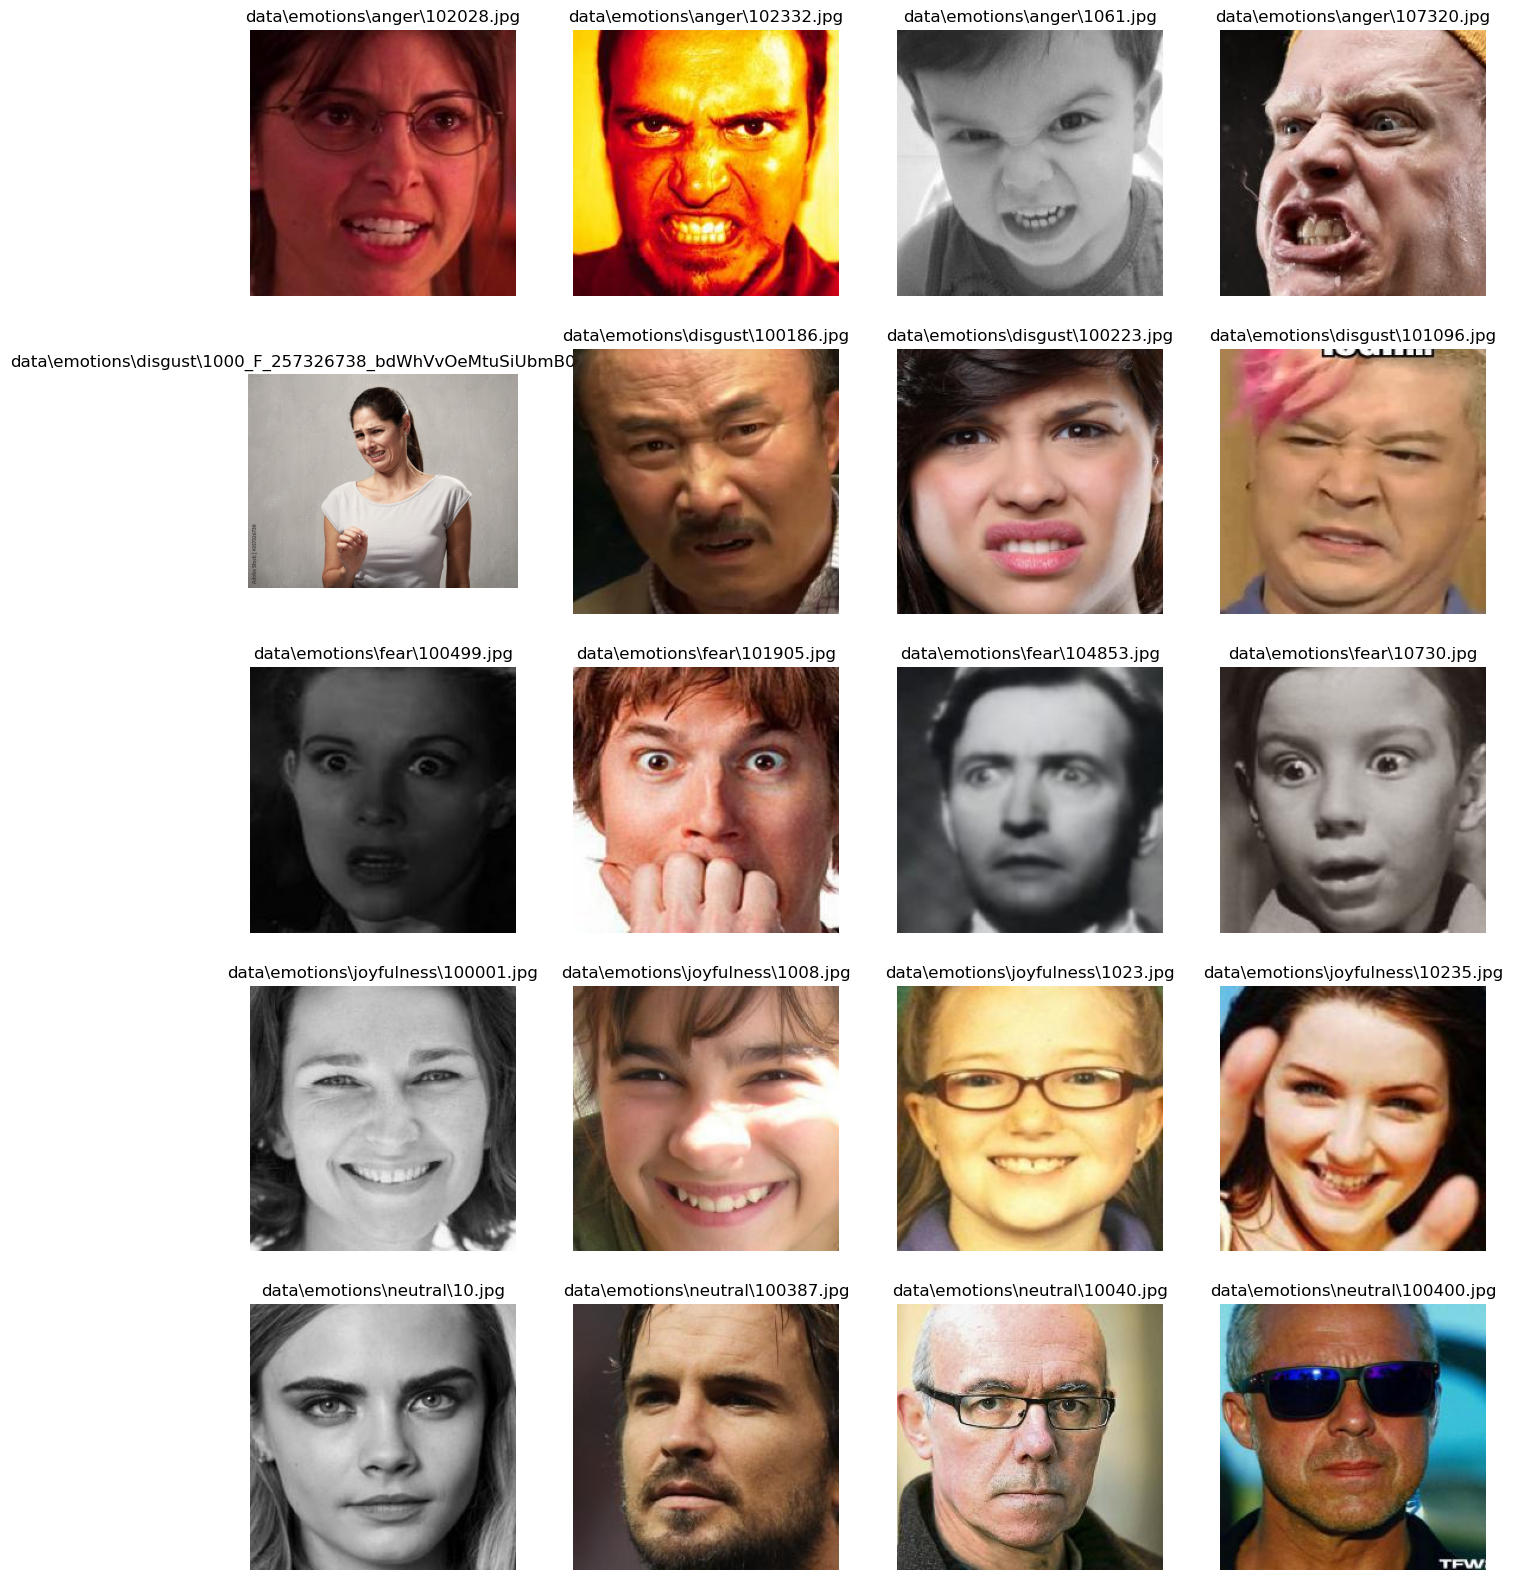

In [18]:
# Запустите эту ячейку несколько раз, чтобы увидеть разные наборы фотографий

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 4

next_anger_pic = [os.path.join(anger_dir, fname)
                for fname in anger_fnames[pic_index-4:pic_index]]
next_disgust_pic = [os.path.join(disgust_dir, fname)
                for fname in disgust_fnames[pic_index-4:pic_index]]
next_fear_pic = [os.path.join(fear_dir, fname)
                for fname in fear_fnames[pic_index-4:pic_index]]
next_joyfulness_pic = [os.path.join(joyfulness_dir, fname)
                for fname in joyfulness_fnames[pic_index-4:pic_index]]
next_neutral_pic = [os.path.join(neutral_dir, fname)
                for fname in neutral_fnames[pic_index-4:pic_index]]


for i, img_path in enumerate(next_anger_pic+next_disgust_pic+
                            next_fear_pic+next_joyfulness_pic+
                            next_neutral_pic):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.axis(False)
    plt.title(img_path)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)


Изображения в имеющихся наборах имеют различное разрешение и соотношение сторон, их необходимо привести к единому стандарту на стадии формирования датасетов для нейронной сети. Этим мы сейчас и займемся.

## Создание датасетов под данную предобученную модель

### Split изображений

Так как готовых инструментов для формирования датасета из трех частей (тренировка, валидация, тест) в tensorflow нет, предварительно необходимо разделить все изображения на соответствующие директории, внутри которых будут папки с классами.

Напишем собственную функцию, которая переместит все изображения по нужным нам папкам, создав, таким образом, необходимое разделение данных на три датасета. Функция содержит вложенную функцию `split_numbers`, которая автоматически определит количество изображений, необходимое для каждого сплита по всем классам в соотношении: `train : validation : test = 8:1:1` (значение по умолчанию). Однако при необходимости это соотношение можно изменить в любую сторону, для этого нужно указать значения для тренировочной и валидационной частей, тестовая часть посчитается автоматически как остаток (при этом нужно помнить, что сумма частей, на которые мы делим датасает, должна быть кратна 10; при желании это правило можно изменить, переписав вложенную функцию).

In [19]:
from pathlib import Path
import shutil
import os

def make_split(files_names, base_dir, class_folder, relation=(8, 1)):
    
    dataset_split_folders = 'train', 'validation', 'test'
    train_dir, val_dir, test_dir = [base_dir / i
                    for i in dataset_split_folders]

    for directory in (train_dir, val_dir, test_dir):
        try:
            Path.mkdir(directory)
        except:
            # print(f'Directory {directory} already exists or cannot be created.')
            pass
        try:
            Path.mkdir(directory / class_folder)
        except:
            # print(f'Directory {directory / class_folder} already exists or cannot be created.')
            pass

    def split_numbers(files_names=files_names):
        imgs_num = len(files_names)
        train_num, val_num = int(imgs_num//10*relation[0]), int(imgs_num//10*relation[1])
        test_num = imgs_num - train_num - val_num
        return train_num, val_num, test_num
        
    examples = split_numbers(files_names)
    directories = train_dir, val_dir, test_dir

    for num, dr in zip(examples, directories):
        i = num
        while i != 0:
            image_name = os.listdir(base_dir / class_folder)[i-1]
            shutil.move(base_dir / class_folder / image_name,
                         dr / class_folder / image_name)
            i -= 1

    shutil.rmtree(base_dir / class_folder)

Применим эту функцию к каждому из классов.

In [20]:
for i in range(len(classes)):
    make_split(files_names[i],
             base_dir=base_dir,
             class_folder=classes[i],
             # изменим немного соотношение в пользу валидации
             relation=(8, 1.2))

Наш датасет разделен на три части в соотношении 8:1:1. Теперь у нас имеются три директории, содержащие папки с нужными нам классами.

In [21]:
for i in os.listdir(base_dir):
    print(i, os.listdir(base_dir / i))

test ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
train ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
validation ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']


### Предобученная модель | MobileNet V2

Для нашей задачи в рамках данной части дипломной работы мы будем использовать предобученную модель `MobileNet V2`, которая отличается от первой версии гораздо меньшим количеством параметров при сохранении высоких предсказательных способностей, что критично для имплементации моделей на мобильные устройства. 

Модель разработана в корпорации "Google" и обучена на основе 1,4 млн. изображений для 1000 классов. Это позволяет нам надеяться на то, что мы сможем дообучить нашу модель с небольшим количеством изображений до приемлемого уровня точности, 80%.

В библиотеке TensorFlow существует как минимум два способа использования предобученных моделей:
- использованием библиотеки моделей `tensorflow-hub`,
- с использованием модуля Keras `tf.keras.applications`.

Первый способ проще в имплементации и очень хорошо годится для производства, однако у него есть существенный недостаток для разработчика - предобученные модели поставляются как единый слой и не подлежат частичной разморозке, разморозить можно только все слои зараз, отчего важным становится правильный выбор версии данной модели (`MobileNet V2` в первом случае рассматривается как семейство моделей). Также два способа отличаются методом `rescale` - в первом случае изображения необходимо привести к стандарту [0, 1], тогда как во втором - [-1, 1]. Это необходимо иметь ввиду при подготовке наших изображений перед отправкой на обучение.

Воспользуемся вторым способом, так как он гораздо более пластичен для тонкой настройки и позволяет экспениментировать с гиперпараметрами. 

### Гиперпараметры для модели с переносом обучения

В самом начале обозначим гиперпараметры для будущей модели, это позволит нам уже сейчас начать подготавливать необходимые команды с этими данными для дальнейшего использования. 

`MobileNet V2` позволяет выбрать любое разрешение выше 32х32, мы будем использовать разрешение 224х224. 

In [22]:
MODULE_HANDLE = 'tf.keras.applications.MobileNetV2'
IMAGE_SIZE = (224, 224)
IMG_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 32

print(f"Используем {MODULE_HANDLE}, входное разрешение: {IMAGE_SIZE}, размер батча: {BATCH_SIZE}.")

Используем tf.keras.applications.MobileNetV2, входное разрешение: (224, 224), размер батча: 32.


### Создание датасетов | `image_dataset_from_directory`

Для обучения модели и затем конвертации ее в облегченную версию все предварительно разделенные по папкам изображения необходимо перевести в формат `dataset`. Для выполнения этой задачи будем использовать метод библиотеки `keras` `image_dataset_from_directory`. В качестве `label_mode` установим `categorical` для перевода лейблов в вид `one_hot_encoding`.

Для корректной работы кода, создающего облегченную версию нашей модели, который мы позаимствовали из курса по компьютерному зрению, тренировочный и валидационный датасеты должны иметь достаточно большой батч, тогда как тестовый датасет должен выдавать по одному изображению зараз, то есть батч должен равняться 1. 

Весь необходимый код оформим в функцию, которая и проделает все операции.

In [23]:
from pathlib import Path

def datasets_prep(base_directory=base_dir,
                  seed=123,
                  batch_size=BATCH_SIZE,
                  image_size=IMAGE_SIZE, 
                  label_mode='categorical'):
    
    train_dir = base_dir / 'train'
    val_dir = base_dir / 'validation'
    test_dir = base_dir / 'test'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
                            train_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
                            val_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
                            test_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=1)  # установим батч = 1
    
    return train_ds, val_ds, test_ds

In [24]:
train_batches, validation_batches, test_batches = datasets_prep()

Found 1080 files belonging to 5 classes.
Found 159 files belonging to 5 classes.
Found 141 files belonging to 5 classes.


Проверим созданные датасеты на соответствие заданным выше параметрам.

In [25]:
for ds in (train_batches, validation_batches, test_batches):
    for image_batch, label_batch in ds.take(1):
        print(image_batch.shape)

(32, 224, 224, 3)
(32, 224, 224, 3)
(1, 224, 224, 3)


Как и требовалось, тренировочный и валидационный датасеты содержат в батче установленное количество изображений, тестовый - 1.

Проверим классы, верно ли отработал данный инструмент.

In [26]:
for ds in (train_batches, validation_batches, test_batches):
    print(ds.class_names)

class_names = train_batches.class_names
num_classes = len(class_names)

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']


### Визуализация изображений из `train_batches`

C:\Users\commi\AppData\Local\Temp\ipykernel_14816\3032689920.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(4, 4, i+1)


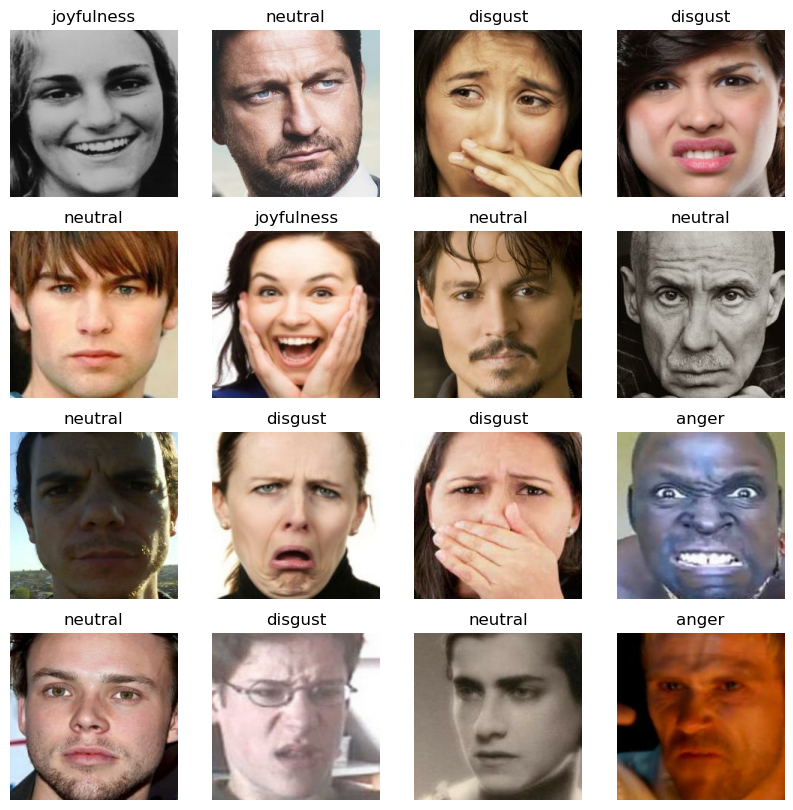

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(10):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        category_class = int(tf.argmax(labels[i]))
        plt.title(class_names[category_class])
        plt.axis('off')

Также возьмем одно из изображений из получившегося датасета и посмотрим, получили ли мы желаемое разрешение. Это изображение пригодится нам в дальнейшм, поэтому сохраним его в переменную `one_pic`.

(224, 224, 3)


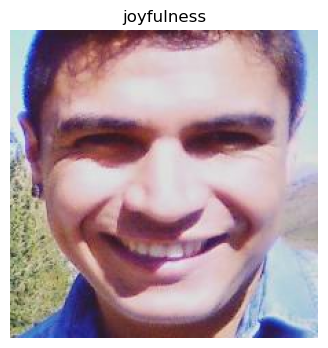

In [28]:
# одно случайное изображение
for images, labels in train_batches.take(30):
    one_pic = images[1].numpy()
    label = labels[1]
    break

print(one_pic.shape)
plt.figure(figsize=(4, 4))
plt.title(class_names[int(tf.argmax(label))])
plt.axis('off')
plt.imshow(one_pic.astype('uint8'));

Итак, датасет для модели создан, все фотографии приведены к единому разрешению, можно переходить к обработке данных для тренировки модели. Обработка данных для нашей модели состоит из двух частей: нормализация значений массива (`rescale`) и агументация данных. Подготовим обе части и запустим две модели - без аугментации и с ней, чтобы посмотреть, как этот блок слоев влияет на работу модели. 

# <b>2. ПОДГОТОВКА ФУНКЦИЙ И ПЕРЕМЕННЫХ ДЛЯ ОБУЧЕНИЯ</b>

## Слои для препроцессинга изображений

### Rescale

Стандартизация значений матриц изображений - обязательная операция, если мы хотим получить хорошие результаты по работе нашей сети. Для использования данной предобученной модели значения матриц изображений необходимо отшкалировать по стандарту от -1 до 1 (именно такой стандарт использовался для обучения этой сети). Есть два способа создания соответствующего слоя:

```python
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

или

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
```

Мы возьмем второй вариант, так как он более пластичен.

Данный слой будет первым в моделях, поэтому необходимо указать `input_shape` входных изображений.

In [29]:
rescale = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./127.5, offset=-1,
                                  input_shape=IMAGE_SIZE + (3,),
                                  name='Rescaling')
])

Проверим качество работы слоя на фотографии, которую мы использовали выше.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Минимальное и максимальное значение пикселей: -1.0 1.0


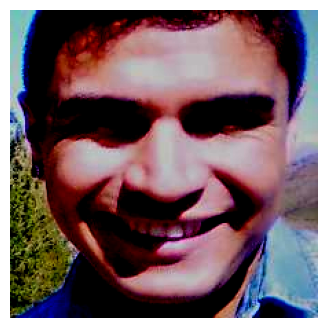

In [30]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через слой
result_for_rescale = rescale(np.expand_dims(one_pic, axis=0))
# print(result_for_rescale.shape)

# вернем результату размерность 3 для отображения
result = np.squeeze(result_for_rescale)
# print(result.shape)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(result)

# print("Picture's shape:", result.shape)
print("Минимальное и максимальное значение пикселей:", result.min(), result.max())

Слой отработал ожидаемым образом, при этом видно, что изменился контраст изображения. Это нормально, так как значения матрицы изображений были растянуты по обе стороны от 0. В любом случае, алгоритм обнаруживает зависимости не по внешнему виду картинок, а исходя из численных значений матриц изображений, контраст имеет значение только для нашего, человеческого глаза.

### Аугментация данных

Так как наш датасет создан из сравнительно небольшого набора данных, то для избежания переобучения мы воспользуемся всеми доступными возможностями библиотеки `keras`, в частности, добавим в модель слои агументации, которые искусственным образом увеличат количество изображений через внешнее изменение имеющихся. 

Создадим последовательность слоев `RandomFlip` (зеркальное отображение изображения в случайном порядке), `RandomRotation` (поворот изображения по часовой стрелке на случайный угол), `RandomZoom` (увеличение и уменьшение изображения в случайном порядке), а также `RandomContrast`. 

In [31]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical', name='RandomFlip'),
    tf.keras.layers.RandomRotation(factor=1, fill_mode='reflect',
                                   name='RandomRotation'),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.3), name='RandomZoom'),
    # tf.keras.layers.RandomContrast(factor=(0.1, 0.1), name='RandomContrast')
])

Как и в случае с созданием датасета, проверим на уже использованном изображении из тренировочного датасета, как работает последовательность по аугментации данных. Если следующий блок с кодом запустить несколько раз, то мы увидим, как меняется изображение, проходя через вышеописанные слои.

> _**Note**: В версии tf 2.11.0 при выполнении нижеследующего кода выводятся предупреждения, которые не влияют на качество работы модели._

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Минимальное и максимальное значение пикселей: -0.84573114 0.9867419


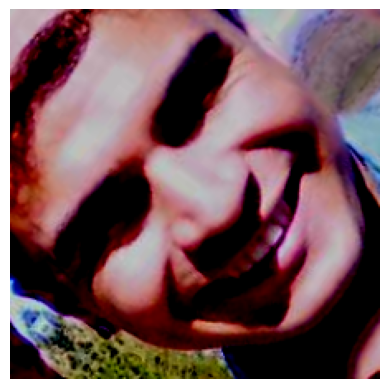

In [32]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через последовательность слоев
result_for_aug = np.expand_dims(result, axis=0)
augmented = data_aug(result_for_aug).numpy()
# print(augmented.shape)

plt.axis('off')

# вернем результату размерность 3 для отображения
plt.imshow(np.squeeze(augmented));

print("Минимальное и максимальное значение пикселей:", augmented.min(), augmented.max())

Видим, что некоторые каналы из-за усиления контрастности дают выжженные пиксели. Эта особенность будет выправлена следующей операцией - `rescale`, которая при приведении значений к стандарту [-1, 1] также влияет на контраст. В итоге мы получим более менее нормализованную картинку. При желании слой с контрастом, как и другие слои аугментации, всегда можно отключить или изменить параметры, но нас устраивает такой результат.

Итак, обе последовательности вполне успешно справляются с поставленными перед ними задачами. Переходим к созданию и обучению моделей.

## Архитектура, компиляция, обучение модели

`DROPOUT_RATE` назначим небольшим, так как датасет у нас скромный по объему, и, если мы будем исключать значительную часть датасета из обучения, модель просто не сможет обучаться.

Также назначим переменную базовый learning rate - `BASE_LR`, установим значение на 0.01. Мы будем использовать специальный инструмент `callbacks`, который при необходимости будет уменьшать данный параметр непосредственно в ходе обучения.

In [366]:
DROPOUT_RATE = 0.1
BASE_LR = 0.01
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)
EPOCHS=500  # см. callbacks

Также пропишем дополнительную метрику для наших  несбалансированных мультиклассов - PR-AUC с использованием precision и recall. PR-AUC - это площадь под графиком этих двух метрик, позволяет учесть данные по редким классам и получить более объективную картину об эффективности обучения.

In [59]:
curve = 'PR'
name = curve+'_AUC'
AUC = tf.keras.metrics.AUC(curve=curve, multi_label=False, name=name)

metrics = ['accuracy', AUC]

### Callbacks - контроль остановки обучения и `learning_rate`

Так как обучение моделей по компьютерному зрению очень затратно по ресурсам, а мы планируем провести целый ряд различных экспериментов, для снижения нагрузки на систему мы будем использовать так называемые `callbacks` - специальные модули `keras`, которые позволяют в автомтическом режиме контролировать, когда следует вносить те или иные изменения в обучение. Мы будем использовать два вида `callbacks`:

- `EarlyStopping` для ранней остановки обучения при прекращении сокращения `val_loss` (для нашего несбалансированного датасета этот показатель важнее, чем непоказательный для несбалансированных классов `val_accuracy`),

- `ReduceLROnPlateau` для уменьшения `learning rate` при ухудшении показателей `val_loss` (Исследователями обнаружено, что постепенное снижение `learning rate` в процессе обучения положительно сказывается на качестве обучения, что мы увидим на наших экспериментах, см. список использованных источников и литературы Holbrook R. "Intro to Deep Learning").

In [367]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,  # минимальное значение для зачета улучшения
    patience=20,  # количество эпох с плохим результатом перед остановкой
    restore_best_weights=True,  # восстановить лучшие показатели модели
)

lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=1,
    factor=0.5,  # на какое значение будет умножаться текущий lr
    min_lr=1e-8,  # минимальное значение lr
)

Таким образом, наши callbacks создают следующий алгоритм: 
- при ухудшении `val_loss` на данной эпохе следующая эпоха будет прходить с `learning rate` в два раза ниже,
- если `val_loss` ухудшается 15 раз кряду, обучение прекращается.

Все эти параметры можно регулировать и подбирать, для наших задач мы остановимся на этих гиперпараметрах, так как они нас устраивают.

## Визуализация итогов обучения

### Функция потерь и метрики

In [153]:
def val_acc_viz(history, epochs, loss_from=1):
    '''
    Функция отрисовывает историю функции потерь и
    используемых метрик. Аргументы:
    - history - данные истории обучения,
    - epochs - количество эпох для отображения,
    - loss_from - с какой эпохи отображать loss.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    auc = history.history[name]
    val_auc = history.history['val_' + name]

    loss = history.history['loss'][loss_from-1:]
    val_loss = history.history['val_loss'][loss_from-1:]

    epochs_range = range(1, len(acc)+1)

    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(loss_from, len(acc)+1), loss, label='Training Loss')
    plt.plot(range(loss_from, len(acc)+1), val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Loss')
    plt.xlabel('epochs')
    # plt.show()

    # plt.figure(figsize=(8, 5))
    # ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 3, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Accuracy')
    plt.xlabel('epochs')

    # plt.subplot(1, 2, 2, sharey=ax1)
    plt.subplot(1, 3, 3, sharey=ax2)
    plt.plot(epochs_range, auc, label='Training ' + name)
    plt.plot(epochs_range, val_auc, label='Validation ' + name)
    plt.legend(loc='best')
    plt.title(name)
    plt.xlabel('epochs')
    plt.show()

### Функция матрицы ошибок

In [169]:
def confusion_matrix(model, images_number=None, dataset=test_batches, class_names=class_names):

    '''
    Выводит матрицу ошибок на тестовых данных. 
    
    Аргументы:
    - model - обученная модель.
    - images_number - количество изображений из тестовой выборки;
            если None, то используются все изображения в выборке.
    - dataset - tf.dataset с тестовыми изображениями.
    '''
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    
    if images_number is None:
        test_images = dataset
    else:
        test_images = dataset.take(images_number)
        
    y_test, y_pred = ([np.argmax(y) for _, y in test_images], 
                      [np.argmax(x) for x in model.predict(test_images)])
        
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='GnBu')
    # disp.plot(cmap='afmhot')

    plt.show()

Для торча.

In [74]:
def confusion_matrix_torch(model, dataset, class_names=class_names):

    '''
    Выводит матрицу ошибок на тестовых данных. 
    
    Аргументы:
    - model - обученная модель.
    - dataset - torch dataloader с тестовыми изображениями.
    '''
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        
    y_test, y_pred = ([np.argmax(y) for _, y in dataset], 
                      [np.argmax(x) for x in model.predict(dataset)])
        
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()

## Предсказания отдельных изображений

### На изображениях из Сети

При желании качество работы модели можно проверить на реальных фотографиях экспертным методом. Для этого создадим новую папку, куда загрузим желаемые изображения. Далее, подготовленная функция преобразует изображения в необходимый для визуализации и предсказания формат. Оставим эту часть в качестве дополнения, использовать ее пока не будем.

In [39]:
# from PIL import Image
# import numpy as np
# from tensorflow.keras.utils import load_img, img_to_array
# import os

# new_test_dir = Path('./data/test_images')
# Path.mkdir(new_test_dir)

# def show_predictions(model):
    
#     images = os.listdir(new_test_dir)
    
#     for i, img_path in enumerate(images):

#         # путь к тестовым изображениям
#         path = new_test_dir / img_path

#         # приведение изображений к желаемому разрешению
#         img = load_img(path, target_size=IMAGE_SIZE + (3,))
#         # перевод изображения в массив
#         x = img_to_array(img)

#         # добавление четвертого измерения для модели
#         images = np.expand_dims(x, axis=0)
        
#         plt.figure(figsize=(2, 2))
#         # Отключить оси
#         plt.axis(False)
#         plt.imshow(np.squeeze(images).astype('uint8'))
#         # plt.title(img_path)
#         plt.show()

#         # предсказание
#         classes = model.predict(images, batch_size=10)

#         class_pred = np.argmax(classes)
#         # print(np.argmax(class_pred))
#         print(f'{img_path} is {class_names[class_pred]} ({np.max(classes[0])*100:.2f}%)')
        
# show_predictions(model)

### На изображениях из тестовой выборки

Посмотрим на то, как модель предсказывает тестовые изображения, хранящиеся в третьей, тестовой выборке, которая до этого момента не принимала участия в работе. Напомним, что тестовая выбора разбита на батчи по одному изображению, что позволяет нам проще контролировать количество изображений, которое мы хотим использовать для предсказания. Следующая функция покажет изображение, заданное и предсказанное значение класса, а также "уверенность" модели в своем предсказании. На данном этапе посмотрим на небольшое количество изображений (по умолчанию 10, можно изменить это число, задав соответствующий аргумент), а полную картину оценим дальше, построив матрицу ошибок.

In [40]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

def show_predictions(model, image_set=test_batches,
                     images_number=10, visualization=False):

    images = image_set.take(images_number)

    for img, label in images:

        if visualization == True:
            plt.figure(figsize=(2, 2))
            # Отключить оси
            plt.axis(False)
            # оставим три измерения из четырех
            image = np.squeeze(img)
            plt.imshow(image.astype('uint8'))
            plt.show()

        # реальный класс
        label = np.argmax(label)
        # предсказанный класс
        prediction = model.predict(img)
        pred = np.argmax(prediction)

        print(f'{class_names[label]} is {class_names[pred]} ({np.max(prediction[0])*100:.2f}%)')

## Оптимизация работы кэша

Оптимизируем работу кэша следующим кодом:

In [76]:
train_batches = train_batches.cache().prefetch(buffer_size=1)
validation_batches = validation_batches.cache().prefetch(buffer_size=1)

# <b>Эксперимент 0 | Оптимизаторы и лосс</b>

In [385]:
stat_0 = dict()

## <b>Модель 0.1 | SGD, MSE</b>

### Архитектура модели

In [376]:
strides = 2

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='SGD_MSE')

model.summary()

Model: "SGD_MSE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_182 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_127 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_183 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_128 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                     

In [377]:
len(model.trainable_variables)

16

### Компиляция

In [378]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [379]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 30s 704ms/step - loss: 3.9535 - accuracy: 0.1944 - PR_AUC: 0.2026 - val_loss: 2.7373 - val_accuracy: 0.2767 - val_PR_AUC: 0.2384 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 23s 688ms/step - loss: 2.0598 - accuracy: 0.2250 - PR_AUC: 0.2237 - val_loss: 1.4544 - val_accuracy: 0.2956 - val_PR_AUC: 0.2380 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 24s 702ms/step - loss: 1.1128 - accuracy: 0.2435 - PR_AUC: 0.2299 - val_loss: 0.8098 - val_accuracy: 0.2956 - val_PR_AUC: 0.2335 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 28s 833ms/step - loss: 0.6367 - accuracy: 0.2528 - PR_AUC: 0.2361 - val_loss: 0.4861 - val_accuracy: 0.2893 - val_PR_AUC: 0.2461 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 28s 815ms/step - loss: 0.3973 - accuracy: 0.2500 - PR_AUC: 0.2498 - val_loss: 0.3242 - val_accuracy: 0.2893 - val_PR_AUC: 0.2397 - lr: 0.0100
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

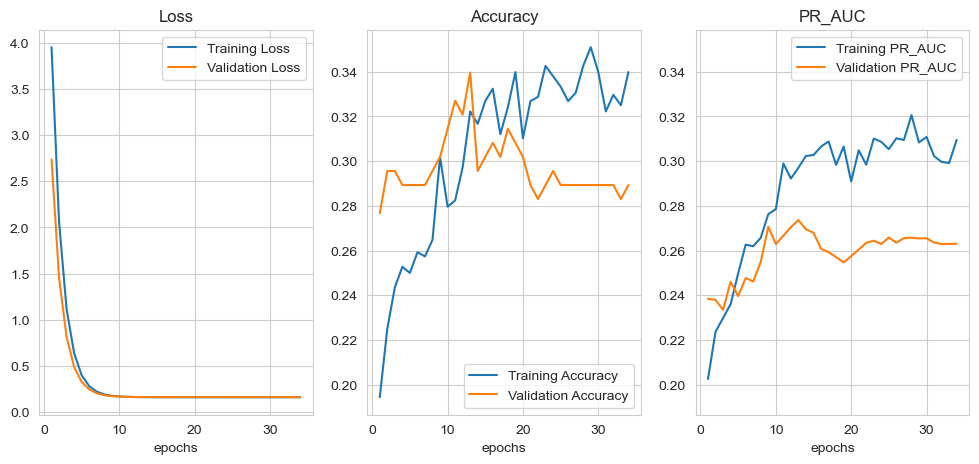

In [380]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [381]:
show_predictions(model, visualization=False)

neutral is neutral (20.52%)
fear is neutral (20.77%)
joyfulness is neutral (20.63%)
joyfulness is neutral (20.50%)
disgust is neutral (20.60%)
neutral is joyfulness (20.66%)
anger is neutral (20.71%)
disgust is neutral (20.86%)
neutral is neutral (20.78%)
disgust is fear (20.54%)


### Матрица ошибок

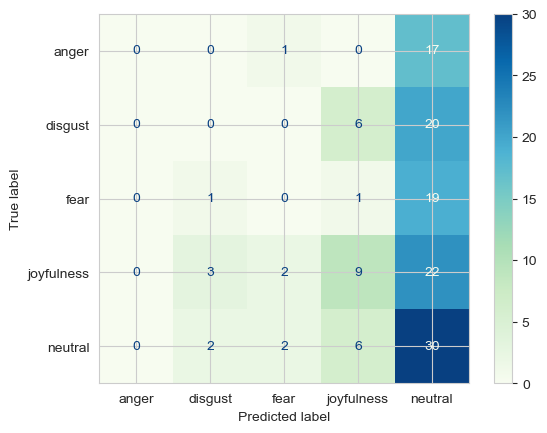

In [382]:
confusion_matrix(model)

### Вывод

In [383]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.34
val_PR_AUC: 0.27


In [384]:
# сохраним данные о модели
model_01 = model
hist_01 = hist

In [386]:
stat_0['sgd_mse'] = model_best_results[1]

In [387]:
stat_0

{'sgd_mse': 0.27}

## <b>Модель 0.2 | SGD, categorical_crossentropy</b>

### Архитектура модели

In [388]:
strides = 2

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='SGD_cat_crossentropy')

model.summary()

Model: "SGD_cat_crossentropy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_186 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_130 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_187 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_131 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                        

In [389]:
len(model.trainable_variables)

16

### Компиляция

In [390]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

### Обучение модели

In [391]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 33s 886ms/step - loss: 5.3524 - accuracy: 0.2287 - PR_AUC: 0.2224 - val_loss: 3.8860 - val_accuracy: 0.2013 - val_PR_AUC: 0.2159 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 24s 687ms/step - loss: 3.3165 - accuracy: 0.2556 - PR_AUC: 0.2395 - val_loss: 2.6931 - val_accuracy: 0.2201 - val_PR_AUC: 0.2301 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 24s 710ms/step - loss: 2.3804 - accuracy: 0.2870 - PR_AUC: 0.2615 - val_loss: 2.1263 - val_accuracy: 0.2453 - val_PR_AUC: 0.2393 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 23s 690ms/step - loss: 1.9444 - accuracy: 0.3019 - PR_AUC: 0.2847 - val_loss: 1.8509 - val_accuracy: 0.2453 - val_PR_AUC: 0.2418 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 26s 753ms/step - loss: 1.7450 - accuracy: 0.3259 - PR_AUC: 0.3036 - val_loss: 1.7169 - val_accuracy: 0.2642 - val_PR_AUC: 0.2482 - lr: 0.0100
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

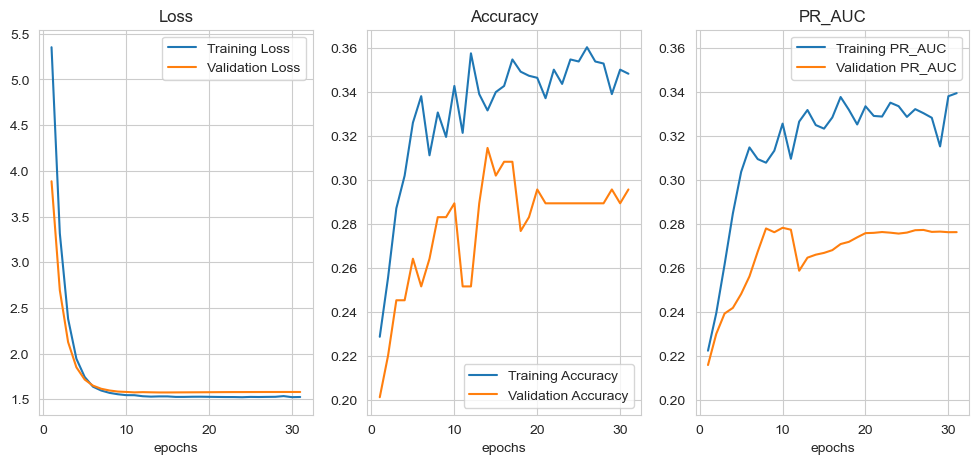

In [392]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [393]:
show_predictions(model, visualization=False)

joyfulness is neutral (24.18%)
fear is neutral (28.33%)
anger is neutral (28.03%)
fear is neutral (27.70%)
neutral is joyfulness (25.16%)
disgust is neutral (26.28%)
neutral is neutral (26.35%)
neutral is joyfulness (26.11%)
neutral is neutral (27.20%)
anger is neutral (24.23%)


### Матрица ошибок

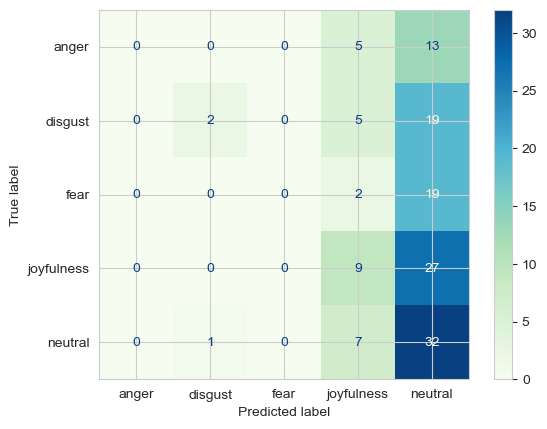

In [394]:
confusion_matrix(model)

### Вывод

In [395]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.28


In [396]:
# сохраним данные о модели
model_02 = model
hist_02 = hist

In [397]:
stat_0['SGD_cat_crossentropy'] = model_best_results[1]

In [398]:
stat_0

{'sgd_mse': 0.27, 'SGD_cat_crossentropy': 0.28}

## <b>Модель 0.3 | Adam, MSE</b>

### Архитектура модели

In [402]:
strides = 2

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='adam_mse')

model.summary()

Model: "SGD_cat_crossentropy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_194 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_136 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_195 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_137 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                        

In [403]:
len(model.trainable_variables)

16

### Компиляция

In [404]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [405]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 29s 713ms/step - loss: 1.2944 - accuracy: 0.2352 - PR_AUC: 0.2278 - val_loss: 0.2195 - val_accuracy: 0.2138 - val_PR_AUC: 0.2042 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 24s 720ms/step - loss: 0.1744 - accuracy: 0.2759 - PR_AUC: 0.2499 - val_loss: 0.1591 - val_accuracy: 0.2893 - val_PR_AUC: 0.2872 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 26s 761ms/step - loss: 0.1573 - accuracy: 0.2870 - PR_AUC: 0.2622 - val_loss: 0.1569 - val_accuracy: 0.2893 - val_PR_AUC: 0.2781 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 32s 936ms/step - loss: 0.1568 - accuracy: 0.2889 - PR_AUC: 0.2589 - val_loss: 0.1566 - val_accuracy: 0.2893 - val_PR_AUC: 0.2777 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 21s 618ms/step - loss: 0.1568 - accuracy: 0.2843 - PR_AUC: 0.2590 - val_loss: 0.1562 - val_accuracy: 0.2956 - val_PR_AUC: 0.2781 - lr: 0.0100
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

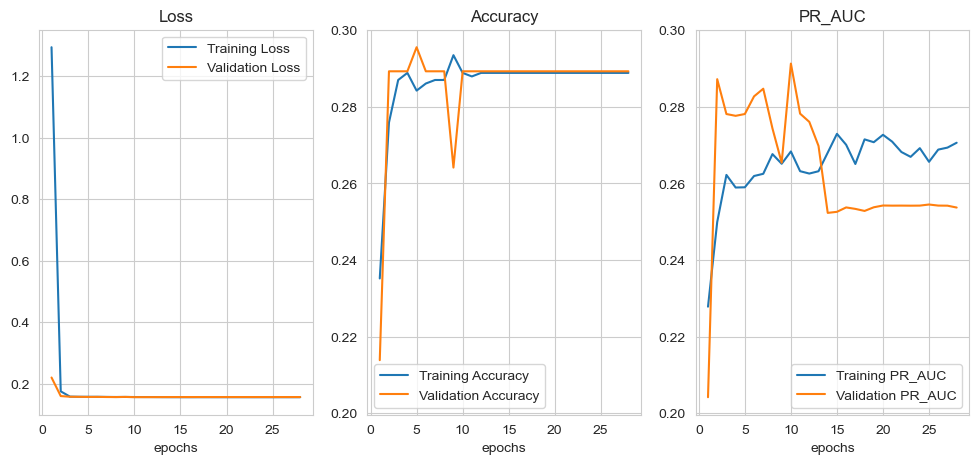

In [406]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [407]:
show_predictions(model, visualization=False)

disgust is neutral (29.75%)
joyfulness is neutral (25.61%)
disgust is neutral (27.92%)
fear is neutral (28.66%)
anger is neutral (28.18%)
joyfulness is neutral (25.94%)
anger is neutral (25.98%)
neutral is neutral (29.02%)
neutral is neutral (29.20%)
neutral is neutral (29.29%)


### Матрица ошибок

In [408]:
confusion_matrix(model)

### Вывод

In [409]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.3
val_PR_AUC: 0.29


In [410]:
# сохраним данные о модели
model_03 = model
hist_03 = hist

In [411]:
stat_0['adam_mse'] = model_best_results[1]

In [412]:
stat_0

{'sgd_mse': 0.27, 'SGD_cat_crossentropy': 0.28, 'adam_mse': 0.29}

## <b>Модель 0.4 | Adam, categorical_crossentropy</b>

### Архитектура модели

In [413]:
strides = 2

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='adam_cat_crossentropy')

model.summary()

Model: "SGD_cat_crossentropy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_198 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_139 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_199 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_140 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                        

In [414]:
len(model.trainable_variables)

16

### Компиляция

In [415]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

### Обучение модели

In [416]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 27s 672ms/step - loss: 3.0159 - accuracy: 0.2444 - PR_AUC: 0.2364 - val_loss: 3.8601 - val_accuracy: 0.1258 - val_PR_AUC: 0.1729 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 22s 657ms/step - loss: 1.5927 - accuracy: 0.2926 - PR_AUC: 0.2704 - val_loss: 1.7037 - val_accuracy: 0.2453 - val_PR_AUC: 0.2161 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 23s 673ms/step - loss: 1.5649 - accuracy: 0.2889 - PR_AUC: 0.2748 - val_loss: 1.6408 - val_accuracy: 0.2642 - val_PR_AUC: 0.2522 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 28s 818ms/step - loss: 1.5631 - accuracy: 0.3093 - PR_AUC: 0.2808 - val_loss: 1.6097 - val_accuracy: 0.2453 - val_PR_AUC: 0.2575 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 26s 776ms/step - loss: 1.5621 - accuracy: 0.2963 - PR_AUC: 0.2802 - val_loss: 1.5894 - val_accuracy: 0.3145 - val_PR_AUC: 0.2742 - lr: 0.0100
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

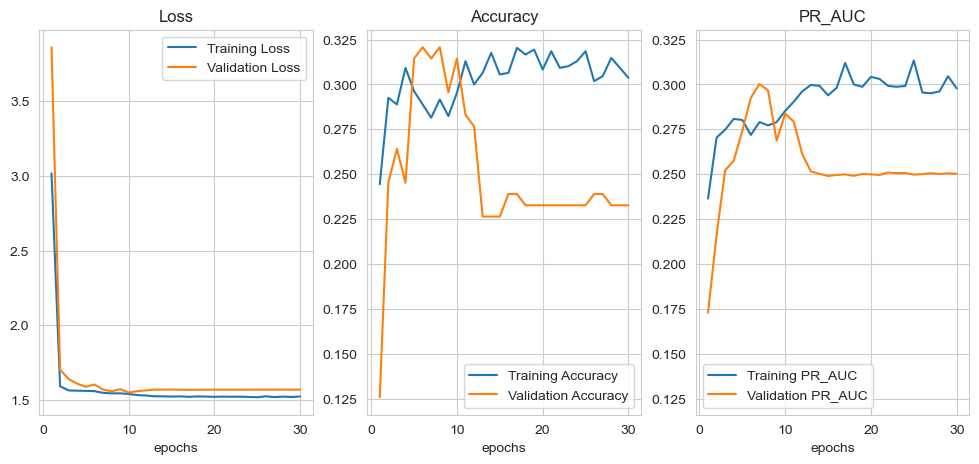

In [417]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [418]:
show_predictions(model, visualization=False)

disgust is neutral (29.33%)
joyfulness is neutral (25.89%)
neutral is neutral (30.84%)
disgust is disgust (29.40%)
neutral is neutral (31.04%)
joyfulness is neutral (26.99%)
fear is neutral (28.87%)
fear is neutral (31.99%)
neutral is neutral (30.01%)
anger is neutral (23.77%)


### Матрица ошибок

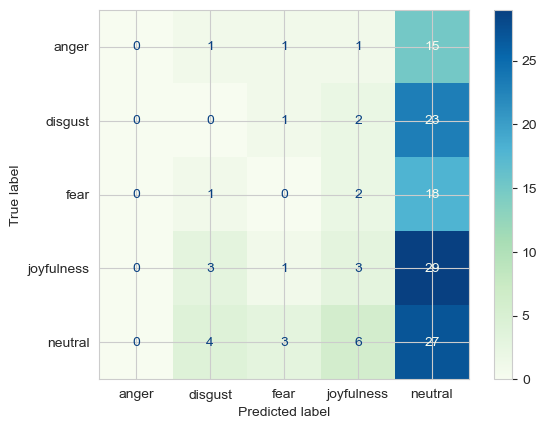

In [419]:
confusion_matrix(model)

### Вывод

In [420]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.32
val_PR_AUC: 0.3


In [421]:
# сохраним данные о модели
model_04 = model
hist_04 = hist

In [422]:
stat_0['adam_cat_crossentropy'] = model_best_results[1]

In [423]:
stat_0

{'sgd_mse': 0.27,
 'SGD_cat_crossentropy': 0.28,
 'adam_mse': 0.29,
 'adam_cat_crossentropy': 0.3}

## <b>Модель 0.5 | RMSprop, MSE</b>

### Архитектура модели

In [425]:
strides = 2

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='RMSprop_mse')

model.summary()

Model: "RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_206 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_207 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                 

In [426]:
len(model.trainable_variables)

16

### Компиляция

In [427]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [428]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 53s 744ms/step - loss: 0.8372 - accuracy: 0.2463 - PR_AUC: 0.2299 - val_loss: 0.1666 - val_accuracy: 0.2138 - val_PR_AUC: 0.2211 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 26s 781ms/step - loss: 0.1610 - accuracy: 0.2870 - PR_AUC: 0.2565 - val_loss: 0.1671 - val_accuracy: 0.2013 - val_PR_AUC: 0.2070 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 27s 791ms/step - loss: 0.1582 - accuracy: 0.2833 - PR_AUC: 0.2625 - val_loss: 0.1607 - val_accuracy: 0.2075 - val_PR_AUC: 0.2268 - lr: 0.0050
Epoch 4/500
34/34 [==============================] - 23s 682ms/step - loss: 0.1583 - accuracy: 0.2954 - PR_AUC: 0.2680 - val_loss: 0.1646 - val_accuracy: 0.2075 - val_PR_AUC: 0.2035 - lr: 0.0050
Epoch 5/500
34/34 [==============================] - 24s 709ms/step - loss: 0.1566 - accuracy: 0.2880 - PR_AUC: 0.2726 - val_loss: 0.1585 - val_accuracy: 0.2767 - val_PR_AUC: 0.2364 - lr: 0.0025
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

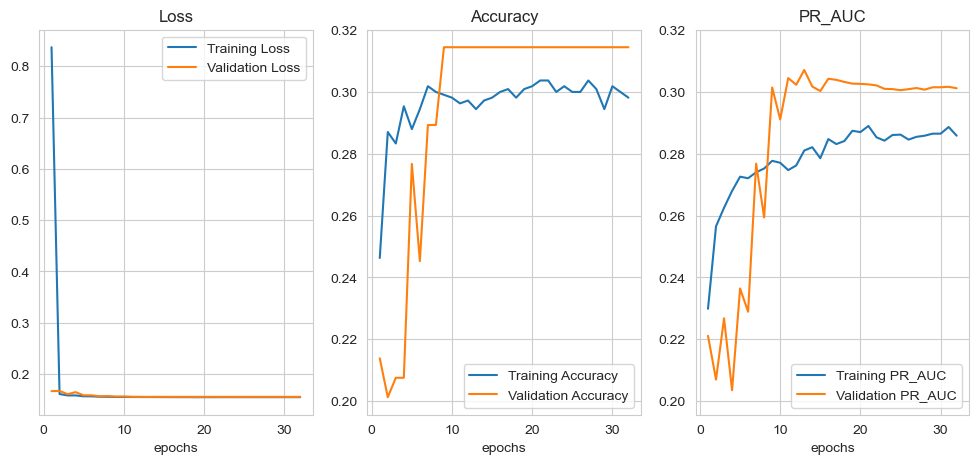

In [429]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [430]:
show_predictions(model, visualization=False)

disgust is neutral (28.80%)
neutral is neutral (29.25%)
neutral is neutral (28.48%)
neutral is neutral (29.29%)
disgust is fear (27.52%)
anger is neutral (25.44%)
joyfulness is neutral (26.83%)
fear is neutral (24.41%)
neutral is neutral (29.29%)
neutral is neutral (28.47%)


### Матрица ошибок

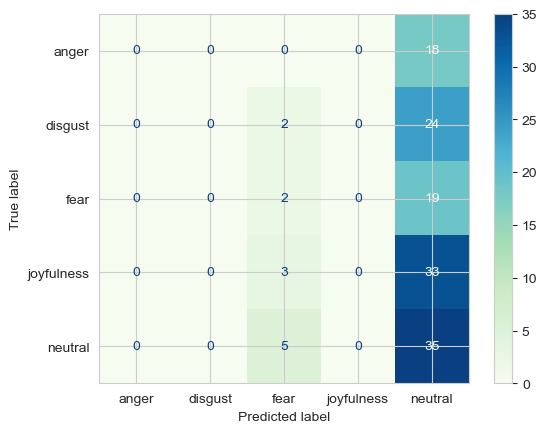

In [431]:
confusion_matrix(model)

### Вывод

In [432]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.31


In [433]:
# сохраним данные о модели
model_05 = model
hist_05 = hist

In [434]:
stat_0['RMSprop_mse'] = model_best_results[1]

In [435]:
stat_0

{'sgd_mse': 0.27,
 'SGD_cat_crossentropy': 0.28,
 'adam_mse': 0.29,
 'adam_cat_crossentropy': 0.3,
 'RMSprop_mse': 0.31}

## <b>Модель 0.6 | RMSprop, categorical_crossentropy</b>

### Архитектура модели

In [436]:
strides = 2

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='RMSprop_cat_crossentropy')

model.summary()

Model: "RMSprop_cat_crossentropy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_210 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_148 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_211 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_149 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                    

In [437]:
len(model.trainable_variables)

16

### Компиляция

In [438]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

### Обучение модели

In [439]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 25s 636ms/step - loss: 2.4905 - accuracy: 0.2648 - PR_AUC: 0.2498 - val_loss: 1.9593 - val_accuracy: 0.1698 - val_PR_AUC: 0.2075 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 21s 623ms/step - loss: 1.5882 - accuracy: 0.2824 - PR_AUC: 0.2750 - val_loss: 2.4547 - val_accuracy: 0.1321 - val_PR_AUC: 0.1821 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 23s 692ms/step - loss: 1.5612 - accuracy: 0.2861 - PR_AUC: 0.2786 - val_loss: 1.8660 - val_accuracy: 0.2138 - val_PR_AUC: 0.2090 - lr: 0.0050
Epoch 4/500
34/34 [==============================] - 25s 729ms/step - loss: 1.5603 - accuracy: 0.2917 - PR_AUC: 0.2790 - val_loss: 1.6487 - val_accuracy: 0.2201 - val_PR_AUC: 0.2243 - lr: 0.0050
Epoch 5/500
34/34 [==============================] - 21s 613ms/step - loss: 1.5579 - accuracy: 0.2852 - PR_AUC: 0.2672 - val_loss: 1.6437 - val_accuracy: 0.3145 - val_PR_AUC: 0.2524 - lr: 0.0050
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

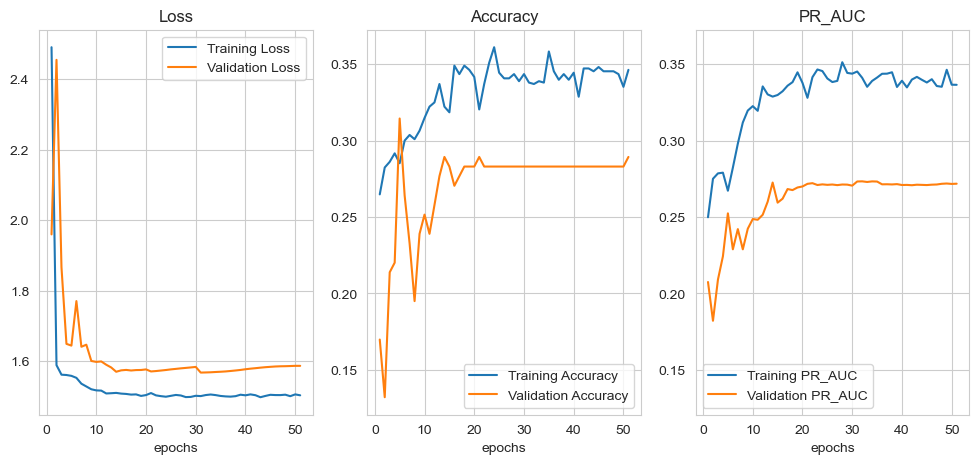

In [440]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [441]:
show_predictions(model, visualization=False)

neutral is neutral (27.85%)
disgust is fear (25.78%)
joyfulness is neutral (24.40%)
neutral is joyfulness (31.15%)
neutral is neutral (27.57%)
fear is neutral (28.37%)
neutral is joyfulness (28.53%)
disgust is disgust (27.89%)
fear is fear (30.74%)
joyfulness is neutral (40.96%)


### Матрица ошибок

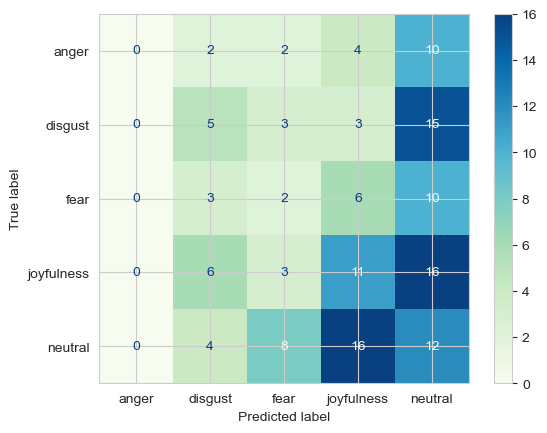

In [442]:
confusion_matrix(model)

### Вывод

In [443]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.27


In [444]:
# сохраним данные о модели
model_06 = model
hist_06 = hist

In [445]:
stat_0['RMSprop_cat_crossentropy'] = model_best_results[1]

In [446]:
stat_0

{'sgd_mse': 0.27,
 'SGD_cat_crossentropy': 0.28,
 'adam_mse': 0.29,
 'adam_cat_crossentropy': 0.3,
 'RMSprop_mse': 0.31,
 'RMSprop_cat_crossentropy': 0.27}

# <b>ЭКСПЕРИМЕНТ 1 | Регуляризаторы L1 и L2</b>

L2 отвечает за уменьшение роли малозначащих признаков, помогает увеличивать качество модели на датасетах, где количество признаков значительно меньше количества примеров, то есть как раз наш случай.

Работаем с RMSprop и mse.

In [462]:
stat_1 = dict()

## <b>Модель 1.1 | L1=0.0, L2=1.0</b>

### Архитектура модели

In [451]:
strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=1.0)

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='RMSprop_mse')

model.summary()

Model: "RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_218 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_154 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_219 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_155 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                 

In [452]:
len(model.trainable_variables)

16

### Компиляция

In [453]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [454]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 31s 760ms/step - loss: 1.5796 - accuracy: 0.2620 - PR_AUC: 0.2436 - val_loss: 0.1710 - val_accuracy: 0.1887 - val_PR_AUC: 0.1947 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 24s 713ms/step - loss: 0.1621 - accuracy: 0.2907 - PR_AUC: 0.2549 - val_loss: 0.1716 - val_accuracy: 0.2201 - val_PR_AUC: 0.1903 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 28s 833ms/step - loss: 0.1585 - accuracy: 0.2833 - PR_AUC: 0.2643 - val_loss: 0.1634 - val_accuracy: 0.2138 - val_PR_AUC: 0.2105 - lr: 0.0050
Epoch 4/500
34/34 [==============================] - 29s 856ms/step - loss: 0.1590 - accuracy: 0.2815 - PR_AUC: 0.2677 - val_loss: 0.1653 - val_accuracy: 0.1761 - val_PR_AUC: 0.2072 - lr: 0.0050
Epoch 5/500
34/34 [==============================] - 25s 739ms/step - loss: 0.1570 - accuracy: 0.2861 - PR_AUC: 0.2639 - val_loss: 0.1590 - val_accuracy: 0.2138 - val_PR_AUC: 0.2156 - lr: 0.0025
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

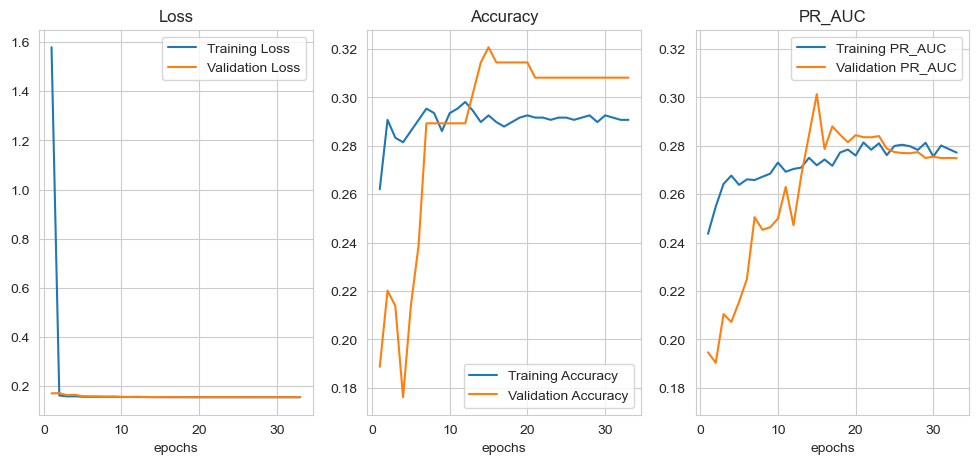

In [455]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [456]:
show_predictions(model, visualization=False)

fear is neutral (27.95%)
disgust is neutral (28.12%)
neutral is neutral (28.55%)
disgust is neutral (27.30%)
neutral is neutral (29.30%)
anger is neutral (28.18%)
neutral is neutral (28.40%)
neutral is neutral (27.49%)
neutral is neutral (28.08%)
joyfulness is neutral (28.84%)


### Матрица ошибок

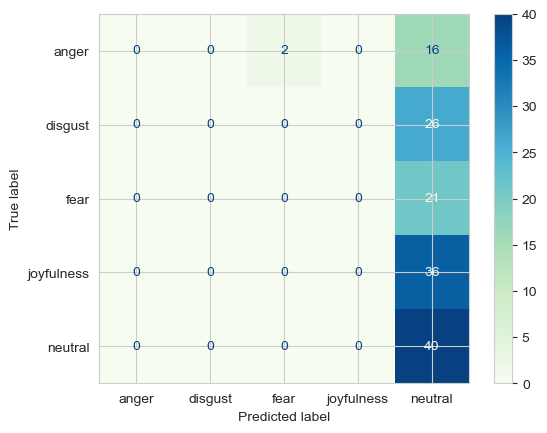

In [457]:
confusion_matrix(model)

### Вывод

In [458]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.32
val_PR_AUC: 0.3


In [460]:
# сохраним данные о модели
model_11 = model
hist_11 = hist

In [463]:
stat_1['L1=0_L2=1'] = model_best_results[1]

In [464]:
stat_1

{'L1=0_L2=1': 0.3}

### Архитектура модели

## <b>Модель 1.2 | L1=0.0, L2=0.25</b>

In [473]:
strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.25)

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='RMSprop_mse')

model.summary()

Model: "RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_230 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_163 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_231 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_164 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                 

In [474]:
len(model.trainable_variables)

16

### Компиляция

In [475]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [476]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 46s 1s/step - loss: 0.5246 - accuracy: 0.2537 - PR_AUC: 0.2459 - val_loss: 0.1682 - val_accuracy: 0.3208 - val_PR_AUC: 0.2193 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 30s 873ms/step - loss: 0.1609 - accuracy: 0.2639 - PR_AUC: 0.2502 - val_loss: 0.1693 - val_accuracy: 0.2390 - val_PR_AUC: 0.2191 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 28s 833ms/step - loss: 0.1581 - accuracy: 0.2963 - PR_AUC: 0.2654 - val_loss: 0.1632 - val_accuracy: 0.3019 - val_PR_AUC: 0.2456 - lr: 0.0050
Epoch 4/500
34/34 [==============================] - 25s 747ms/step - loss: 0.1578 - accuracy: 0.2824 - PR_AUC: 0.2632 - val_loss: 0.1583 - val_accuracy: 0.2893 - val_PR_AUC: 0.2738 - lr: 0.0050
Epoch 5/500
34/34 [==============================] - 34s 1s/step - loss: 0.1576 - accuracy: 0.2898 - PR_AUC: 0.2690 - val_loss: 0.1596 - val_accuracy: 0.3019 - val_PR_AUC: 0.2563 - lr: 0.0050
Epoch 6/500
34/34 [============

### Визуализация данных по работе алгоритма

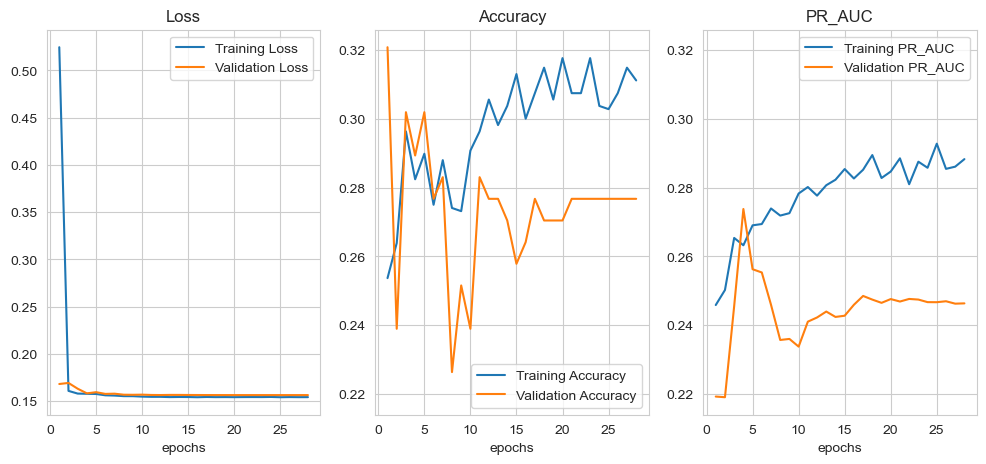

In [477]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [478]:
show_predictions(model, visualization=False)

disgust is neutral (28.69%)
fear is neutral (29.98%)
joyfulness is neutral (29.44%)
neutral is joyfulness (26.16%)
neutral is neutral (27.97%)
neutral is joyfulness (27.50%)
neutral is joyfulness (27.03%)
neutral is joyfulness (27.76%)
anger is neutral (30.24%)
neutral is neutral (26.45%)


### Матрица ошибок

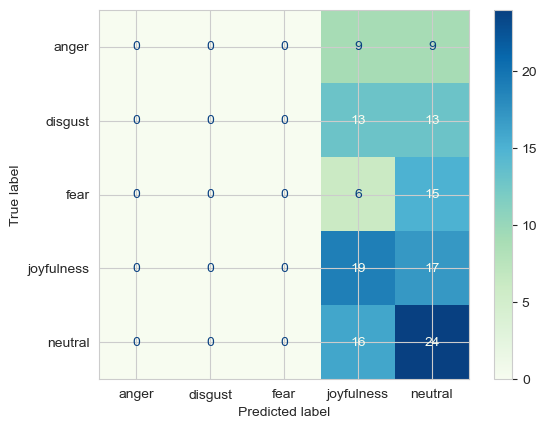

In [479]:
confusion_matrix(model)

### Вывод

In [480]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.32
val_PR_AUC: 0.27


In [481]:
# сохраним данные о модели
model_12 = model
hist_12 = hist

In [482]:
stat_1['L1=0_L2=0.25'] = model_best_results[1]

In [483]:
stat_1

{'L1=0_L2=1': 0.3, 'L1=0_L2=0.25': 0.27}

## <b>Модель 1.3 | L1=0.0, L2=0.75</b>

In [484]:
strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.75)

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='RMSprop_mse')

model.summary()

Model: "RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_234 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_166 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_235 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_167 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                 

In [485]:
len(model.trainable_variables)

16

### Компиляция

In [486]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [487]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 41s 1s/step - loss: 1.2466 - accuracy: 0.2574 - PR_AUC: 0.2358 - val_loss: 0.1674 - val_accuracy: 0.2201 - val_PR_AUC: 0.2216 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 26s 761ms/step - loss: 0.1616 - accuracy: 0.2824 - PR_AUC: 0.2510 - val_loss: 0.1666 - val_accuracy: 0.2075 - val_PR_AUC: 0.2069 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 25s 734ms/step - loss: 0.1635 - accuracy: 0.2843 - PR_AUC: 0.2607 - val_loss: 0.1698 - val_accuracy: 0.2138 - val_PR_AUC: 0.2143 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 25s 743ms/step - loss: 0.1584 - accuracy: 0.2796 - PR_AUC: 0.2627 - val_loss: 0.1624 - val_accuracy: 0.1824 - val_PR_AUC: 0.2125 - lr: 0.0050
Epoch 5/500
34/34 [==============================] - 29s 862ms/step - loss: 0.1584 - accuracy: 0.2852 - PR_AUC: 0.2638 - val_loss: 0.1654 - val_accuracy: 0.1447 - val_PR_AUC: 0.1986 - lr: 0.0050
Epoch 6/500
34/34 [=========

### Визуализация данных по работе алгоритма

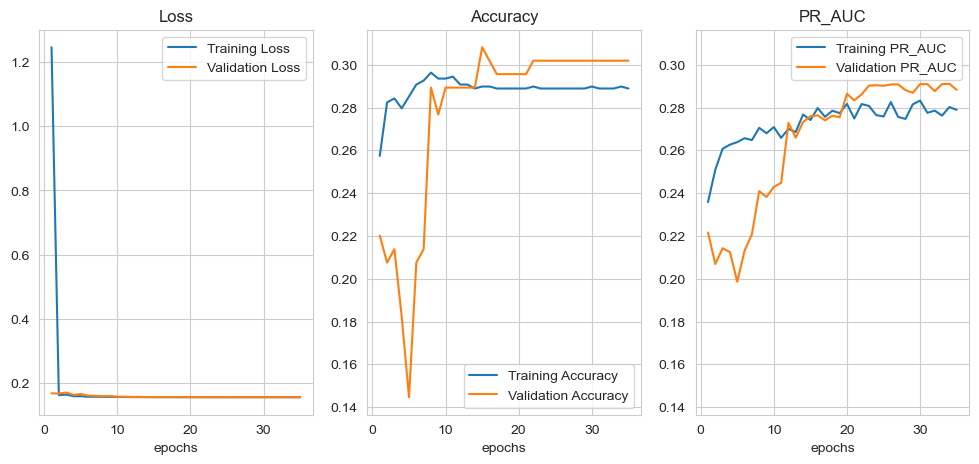

In [495]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [496]:
show_predictions(model, visualization=False)

neutral is neutral (28.50%)
joyfulness is neutral (28.89%)
fear is neutral (27.23%)
fear is neutral (28.70%)
neutral is neutral (29.08%)
anger is neutral (24.66%)
neutral is neutral (28.74%)
disgust is neutral (25.52%)
neutral is neutral (29.14%)
disgust is neutral (26.00%)


### Матрица ошибок

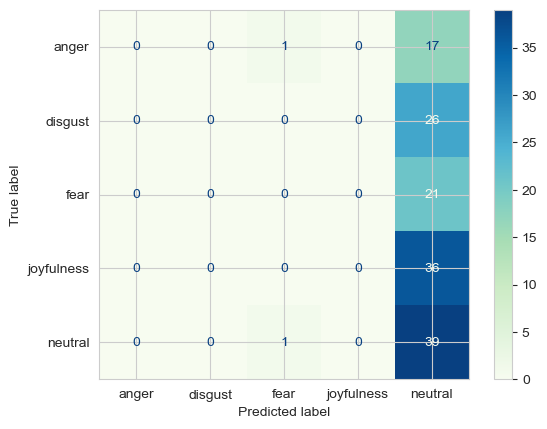

In [498]:
confusion_matrix(model)

### Вывод

In [499]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.29


In [500]:
# сохраним данные о модели
model_13 = model
hist_13 = hist

In [501]:
stat_1['L1=0_L2=0.75'] = model_best_results[1]

In [502]:
stat_1

{'L1=0_L2=1': 0.3, 'L1=0_L2=0.25': 0.27, 'L1=0_L2=0.75': 0.29}

## <b>Модель 1.4 | L1=0.0, L2=0.375</b>

In [503]:
strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.375)

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='RMSprop_mse')

model.summary()

Model: "RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_238 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_169 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_239 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_170 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                 

In [504]:
len(model.trainable_variables)

16

### Компиляция

In [505]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [506]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 37s 898ms/step - loss: 0.6891 - accuracy: 0.2815 - PR_AUC: 0.2565 - val_loss: 0.1736 - val_accuracy: 0.1950 - val_PR_AUC: 0.1996 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 25s 746ms/step - loss: 0.1609 - accuracy: 0.2750 - PR_AUC: 0.2548 - val_loss: 0.1737 - val_accuracy: 0.1824 - val_PR_AUC: 0.2039 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 26s 777ms/step - loss: 0.1581 - accuracy: 0.2843 - PR_AUC: 0.2693 - val_loss: 0.1700 - val_accuracy: 0.1950 - val_PR_AUC: 0.1947 - lr: 0.0050
Epoch 4/500
34/34 [==============================] - 27s 792ms/step - loss: 0.1580 - accuracy: 0.2815 - PR_AUC: 0.2673 - val_loss: 0.1605 - val_accuracy: 0.2516 - val_PR_AUC: 0.2355 - lr: 0.0050
Epoch 5/500
34/34 [==============================] - 31s 915ms/step - loss: 0.1579 - accuracy: 0.2963 - PR_AUC: 0.2686 - val_loss: 0.1642 - val_accuracy: 0.1887 - val_PR_AUC: 0.2158 - lr: 0.0050
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

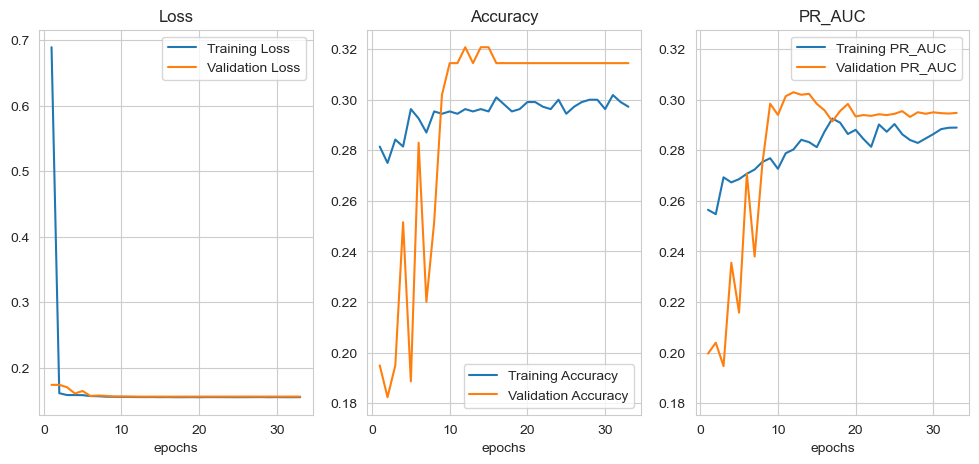

In [507]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [508]:
show_predictions(model, visualization=False)

joyfulness is neutral (27.52%)
joyfulness is neutral (28.12%)
neutral is neutral (28.54%)
fear is neutral (28.01%)
neutral is neutral (29.13%)
neutral is neutral (29.22%)
anger is neutral (25.45%)
neutral is neutral (29.21%)
anger is neutral (25.00%)
disgust is neutral (28.34%)


### Матрица ошибок

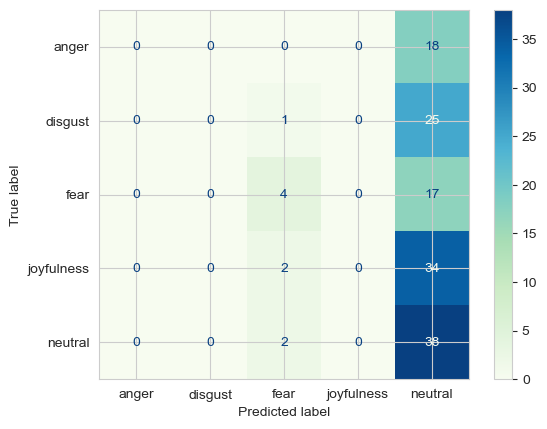

In [509]:
confusion_matrix(model)

### Вывод

In [510]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.32
val_PR_AUC: 0.3


In [511]:
# сохраним данные о модели
model_14 = model
hist_14 = hist

In [512]:
stat_1['L1=0_L2=0.375'] = model_best_results[1]

In [515]:
stat_1

{'L1=0_L2=1': 0.3,
 'L1=0_L2=0.25': 0.27,
 'L1=0_L2=0.75': 0.29,
 'L1=0_L2=0.375': 0.3,
 'L1=0_L2=0.5': 0.31}

## <b>Модель 1.5 | L1=0.0, L2=0.625</b>

In [516]:
strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.625)

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='RMSprop_mse')

model.summary()

Model: "RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_242 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_172 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_243 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_173 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                 

In [517]:
len(model.trainable_variables)

16

### Компиляция

In [518]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [519]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 31s 803ms/step - loss: 0.9436 - accuracy: 0.2481 - PR_AUC: 0.2410 - val_loss: 0.1727 - val_accuracy: 0.1761 - val_PR_AUC: 0.2062 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 27s 788ms/step - loss: 0.1616 - accuracy: 0.2917 - PR_AUC: 0.2539 - val_loss: 0.1710 - val_accuracy: 0.2264 - val_PR_AUC: 0.2328 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 32s 953ms/step - loss: 0.1634 - accuracy: 0.2870 - PR_AUC: 0.2509 - val_loss: 0.1644 - val_accuracy: 0.2579 - val_PR_AUC: 0.2543 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 31s 896ms/step - loss: 0.1629 - accuracy: 0.2889 - PR_AUC: 0.2593 - val_loss: 0.2320 - val_accuracy: 0.1195 - val_PR_AUC: 0.1914 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 27s 796ms/step - loss: 0.1580 - accuracy: 0.2963 - PR_AUC: 0.2617 - val_loss: 0.1607 - val_accuracy: 0.2579 - val_PR_AUC: 0.2470 - lr: 0.0050
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

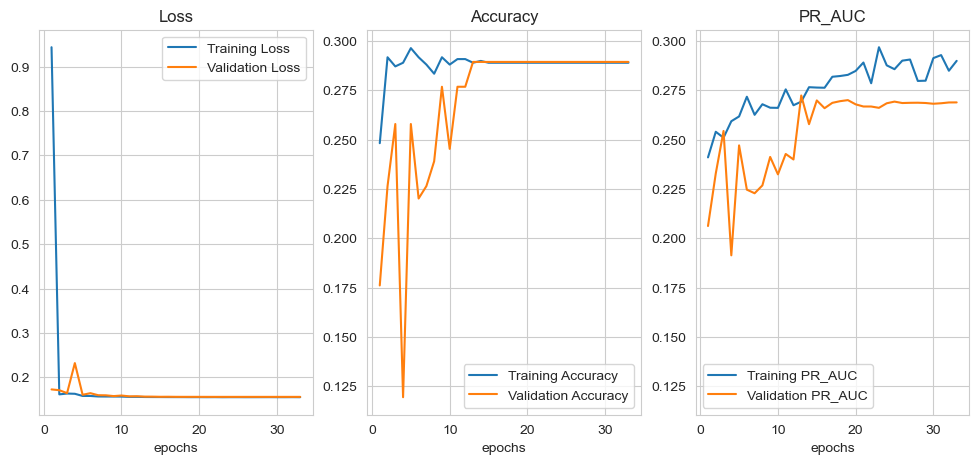

In [520]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [521]:
show_predictions(model, visualization=False)

disgust is neutral (27.51%)
anger is neutral (28.60%)
disgust is neutral (28.23%)
neutral is neutral (28.78%)
fear is neutral (28.66%)
joyfulness is neutral (28.56%)
anger is neutral (28.08%)
joyfulness is neutral (28.88%)
neutral is neutral (28.86%)
neutral is neutral (28.18%)


### Матрица ошибок

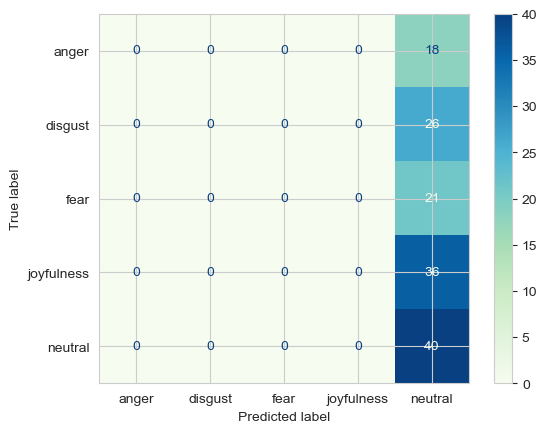

In [522]:
confusion_matrix(model)

### Вывод

In [523]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.29
val_PR_AUC: 0.27


In [524]:
# сохраним данные о модели
model_15 = model
hist_15 = hist

In [525]:
stat_1['L1=0_L2=0.625'] = model_best_results[1]

In [529]:
stat_1

{'L1=0_L2=1': 0.3,
 'L1=0_L2=0.25': 0.27,
 'L1=0_L2=0.75': 0.29,
 'L1=0_L2=0.375': 0.3,
 'L1=0_L2=0.5': 0.31,
 'L1=0_L2=0.625': 0.27}

# <b>ЭКСПЕРИМЕНТ 2 | LR optimizers</b>

Отключаем lr callback и пробуем оптимизаторы на модели 05.

In [554]:
stat_2 = dict()

## <b>Модель 2.1 | CosineDecay L2=0.5</b>

### Архитектура модели

In [541]:
strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='RMSprop_mse')

model.summary()

Model: "RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_254 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_181 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_255 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_182 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                 

In [542]:
len(model.trainable_variables)

16

### Компиляция

In [543]:
decay_steps = 1000
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    BASE_LR*10, decay_steps)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_decayed_fn),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [544]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping])

Epoch 1/500
34/34 [==============================] - 43s 1s/step - loss: 0.7322 - accuracy: 0.2574 - PR_AUC: 0.2431 - val_loss: 0.7696 - val_accuracy: 0.2893 - val_PR_AUC: 0.2389
Epoch 2/500
34/34 [==============================] - 32s 912ms/step - loss: 0.5557 - accuracy: 0.2491 - PR_AUC: 0.2403 - val_loss: 0.6357 - val_accuracy: 0.1132 - val_PR_AUC: 0.1837
Epoch 3/500
34/34 [==============================] - 29s 858ms/step - loss: 0.5384 - accuracy: 0.2509 - PR_AUC: 0.2407 - val_loss: 0.6385 - val_accuracy: 0.1195 - val_PR_AUC: 0.1672
Epoch 4/500
34/34 [==============================] - 36s 1s/step - loss: 0.5266 - accuracy: 0.2472 - PR_AUC: 0.2398 - val_loss: 0.5218 - val_accuracy: 0.3145 - val_PR_AUC: 0.2736
Epoch 5/500
34/34 [==============================] - 33s 957ms/step - loss: 0.5059 - accuracy: 0.2472 - PR_AUC: 0.2483 - val_loss: 0.5846 - val_accuracy: 0.2642 - val_PR_AUC: 0.2409
Epoch 6/500
34/34 [==============================] - 30s 878ms/step - loss: 0.4893 - accuracy: 0

### Визуализация данных по работе алгоритма

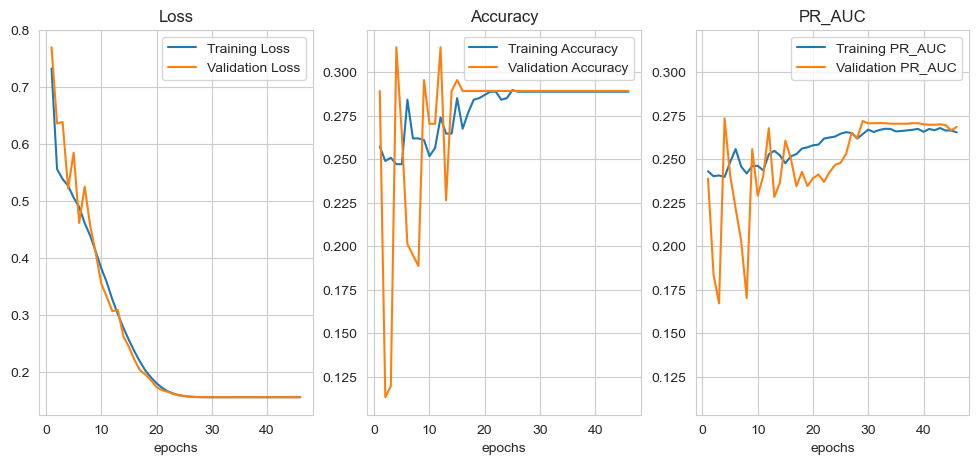

In [545]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [546]:
show_predictions(model, visualization=False)

neutral is neutral (27.70%)
neutral is neutral (27.88%)
disgust is neutral (27.41%)
joyfulness is neutral (28.36%)
neutral is neutral (28.01%)
neutral is neutral (27.87%)
fear is neutral (28.07%)
anger is neutral (27.86%)
anger is neutral (28.54%)
disgust is neutral (28.19%)


### Матрица ошибок

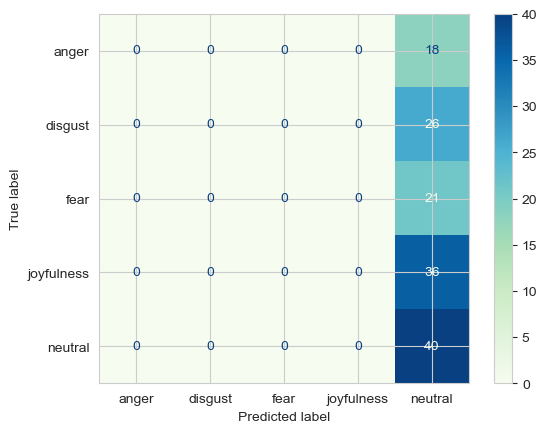

In [547]:
confusion_matrix(model)

### Вывод

In [548]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.27


In [549]:
# сохраним данные о модели
model_21 = model
hist_21 = hist

In [555]:
stat_2['CosineDecay'] = model_best_results[1]

In [556]:
stat_2

{'CosineDecay': 0.27}

## <b>Модель 2.2 | ExponentialDecay L2=0.5</b>

### Архитектура модели

In [557]:
strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='RMSprop_mse')

model.summary()

Model: "RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_258 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_184 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_259 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_185 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                 

In [558]:
len(model.trainable_variables)

16

### Компиляция

In [559]:
lr_decayed_fn = tf.keras.optimizers.schedules.ExponentialDecay(
    BASE_LR,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_decayed_fn),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [560]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping])

Epoch 1/500
34/34 [==============================] - 33s 799ms/step - loss: 0.8666 - accuracy: 0.2611 - PR_AUC: 0.2507 - val_loss: 0.1704 - val_accuracy: 0.1321 - val_PR_AUC: 0.1986
Epoch 2/500
34/34 [==============================] - 27s 804ms/step - loss: 0.1611 - accuracy: 0.2722 - PR_AUC: 0.2491 - val_loss: 0.1720 - val_accuracy: 0.1635 - val_PR_AUC: 0.2022
Epoch 3/500
34/34 [==============================] - 28s 811ms/step - loss: 0.1625 - accuracy: 0.2917 - PR_AUC: 0.2535 - val_loss: 0.1704 - val_accuracy: 0.1950 - val_PR_AUC: 0.2172
Epoch 4/500
34/34 [==============================] - 32s 935ms/step - loss: 0.1616 - accuracy: 0.2963 - PR_AUC: 0.2712 - val_loss: 0.1658 - val_accuracy: 0.2956 - val_PR_AUC: 0.2697
Epoch 5/500
34/34 [==============================] - 28s 811ms/step - loss: 0.1624 - accuracy: 0.2731 - PR_AUC: 0.2507 - val_loss: 0.1670 - val_accuracy: 0.2327 - val_PR_AUC: 0.2247
Epoch 6/500
34/34 [==============================] - 26s 776ms/step - loss: 0.1613 - accur

### Визуализация данных по работе алгоритма

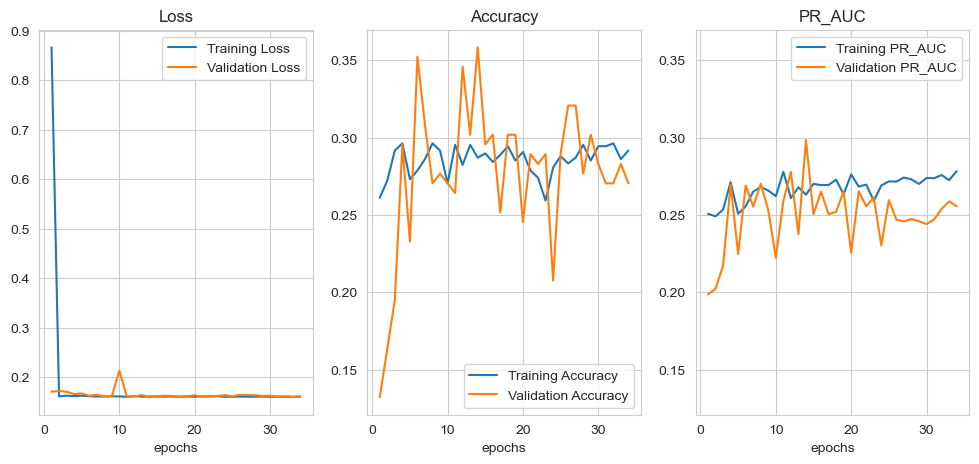

In [561]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [562]:
show_predictions(model, visualization=False)

disgust is disgust (24.70%)
anger is disgust (24.65%)
disgust is neutral (27.88%)
neutral is neutral (27.94%)
neutral is disgust (25.45%)
fear is fear (28.65%)
joyfulness is fear (28.35%)
neutral is neutral (25.70%)
anger is disgust (25.12%)
neutral is neutral (27.65%)


### Матрица ошибок

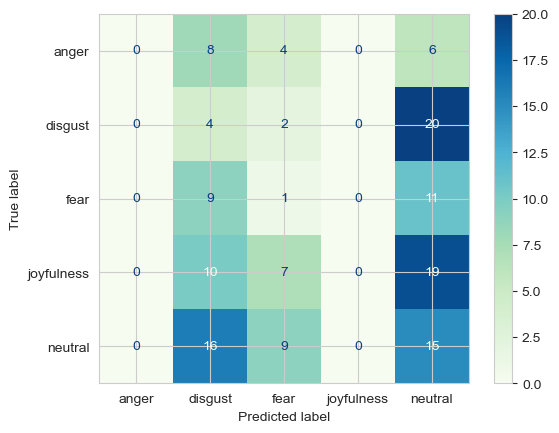

In [563]:
confusion_matrix(model)

### Вывод

In [564]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.36
val_PR_AUC: 0.3


In [569]:
# сохраним данные о модели
model_22 = model
hist_22 = hist

In [568]:
stat_2['ExponentialDecay'] = model_best_results[1]

In [570]:
stat_2

{'CosineDecay': 0.3, 'ExponentialDecay': 0.3}

## <b>Модель 2.3 | PolynomialDecay L2=0.5</b>

### Архитектура модели

In [571]:
strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='RMSprop_mse')

model.summary()

Model: "RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_262 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_187 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_263 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_188 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                 

In [572]:
len(model.trainable_variables)

16

### Компиляция

In [573]:
end_learning_rate = 0.0001
decay_steps = 10000
lr_decayed_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    BASE_LR,
    decay_steps,
    end_learning_rate,
    power=0.5)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_decayed_fn),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [574]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping])

Epoch 1/500
34/34 [==============================] - 33s 799ms/step - loss: 0.8276 - accuracy: 0.2528 - PR_AUC: 0.2377 - val_loss: 0.1717 - val_accuracy: 0.1447 - val_PR_AUC: 0.1908
Epoch 2/500
34/34 [==============================] - 27s 799ms/step - loss: 0.1609 - accuracy: 0.2880 - PR_AUC: 0.2610 - val_loss: 0.1800 - val_accuracy: 0.2390 - val_PR_AUC: 0.2000
Epoch 3/500
34/34 [==============================] - 31s 911ms/step - loss: 0.1616 - accuracy: 0.2741 - PR_AUC: 0.2646 - val_loss: 0.2073 - val_accuracy: 0.2390 - val_PR_AUC: 0.1985
Epoch 4/500
34/34 [==============================] - 34s 999ms/step - loss: 0.1624 - accuracy: 0.2676 - PR_AUC: 0.2567 - val_loss: 0.1759 - val_accuracy: 0.1824 - val_PR_AUC: 0.1832
Epoch 5/500
34/34 [==============================] - 27s 782ms/step - loss: 0.1615 - accuracy: 0.2852 - PR_AUC: 0.2600 - val_loss: 0.1712 - val_accuracy: 0.1950 - val_PR_AUC: 0.1822
Epoch 6/500
34/34 [==============================] - 28s 830ms/step - loss: 0.1611 - accur

### Визуализация данных по работе алгоритма

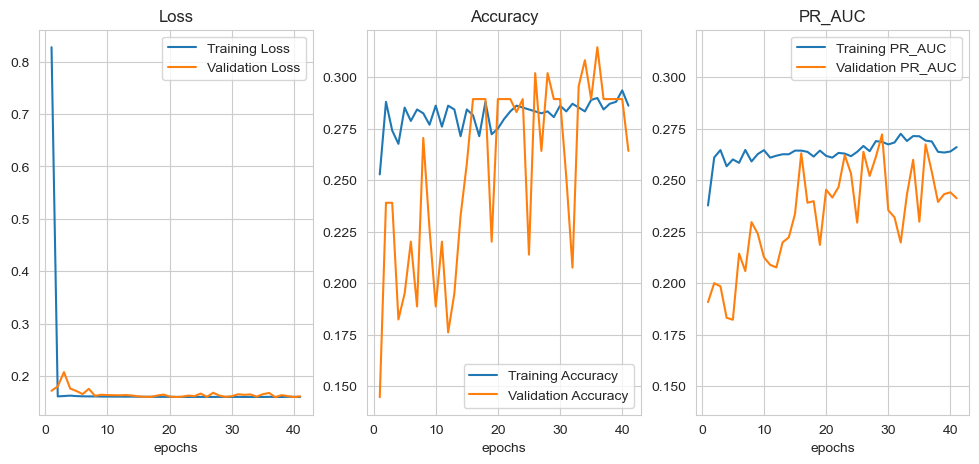

In [575]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [576]:
show_predictions(model, visualization=False)

fear is neutral (29.07%)
joyfulness is neutral (28.28%)
neutral is neutral (27.38%)
disgust is neutral (27.55%)
fear is neutral (28.44%)
anger is neutral (29.97%)
disgust is neutral (29.31%)
joyfulness is neutral (28.46%)
neutral is neutral (27.34%)
neutral is neutral (27.54%)


### Матрица ошибок

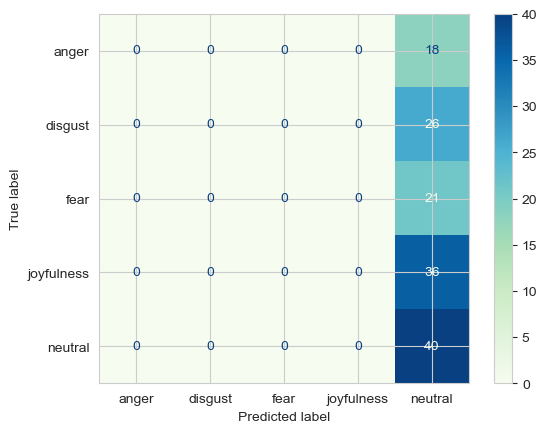

In [577]:
confusion_matrix(model)

### Вывод

In [578]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.27


In [579]:
# сохраним данные о модели
model_23 = model
hist_23 = hist

In [580]:
stat_2['PolynomialDecay'] = model_best_results[1]

In [583]:
stat_2

{'CosineDecay': 0.3,
 'ExponentialDecay': 0.3,
 'PolynomialDecay': 0.27,
 'MyCallback': 0.31}

# <b>ЭКСПЕРИМЕНТ 3 | Модель вширь</b>

В качестве базовой взята модель 05.

In [584]:
stat_3 = dict()

## <b>Модель 3.1 | RMSprop 1024 нейронов</b>

### Архитектура модели

In [585]:
strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1024, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='RMSprop_mse')

model.summary()

Model: "RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_266 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_190 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_267 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_191 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                 

In [586]:
len(model.trainable_variables)

16

### Компиляция

In [587]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [588]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 161s 1s/step - loss: 0.4633 - accuracy: 0.2213 - PR_AUC: 0.2178 - val_loss: 0.2786 - val_accuracy: 0.1069 - val_PR_AUC: 0.1612 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 32s 932ms/step - loss: 0.2300 - accuracy: 0.2472 - PR_AUC: 0.2298 - val_loss: 0.4089 - val_accuracy: 0.1321 - val_PR_AUC: 0.1730 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 27s 800ms/step - loss: 0.1760 - accuracy: 0.2583 - PR_AUC: 0.2488 - val_loss: 0.1909 - val_accuracy: 0.1635 - val_PR_AUC: 0.1999 - lr: 0.0050
Epoch 4/500
34/34 [==============================] - 27s 800ms/step - loss: 0.1781 - accuracy: 0.2898 - PR_AUC: 0.2576 - val_loss: 0.1847 - val_accuracy: 0.2390 - val_PR_AUC: 0.2187 - lr: 0.0050
Epoch 5/500
34/34 [==============================] - 29s 850ms/step - loss: 0.1768 - accuracy: 0.2815 - PR_AUC: 0.2594 - val_loss: 0.1751 - val_accuracy: 0.2893 - val_PR_AUC: 0.2611 - lr: 0.0050
Epoch 6/500
34/34 [========

### Визуализация данных по работе алгоритма

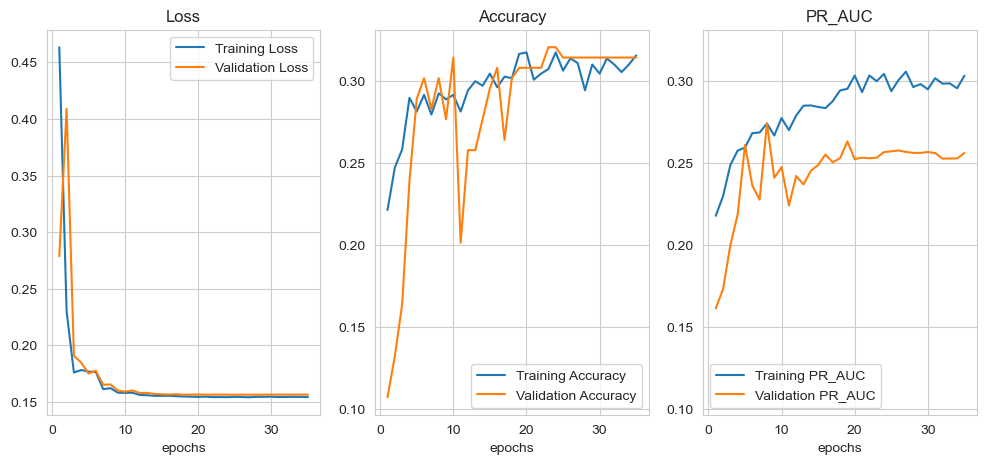

In [589]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [590]:
show_predictions(model, visualization=False)

disgust is neutral (28.32%)
disgust is disgust (25.74%)
joyfulness is neutral (28.87%)
joyfulness is neutral (28.47%)
neutral is neutral (27.17%)
anger is neutral (28.72%)
neutral is neutral (27.13%)
neutral is neutral (28.04%)
neutral is neutral (27.43%)
disgust is neutral (29.54%)


### Матрица ошибок

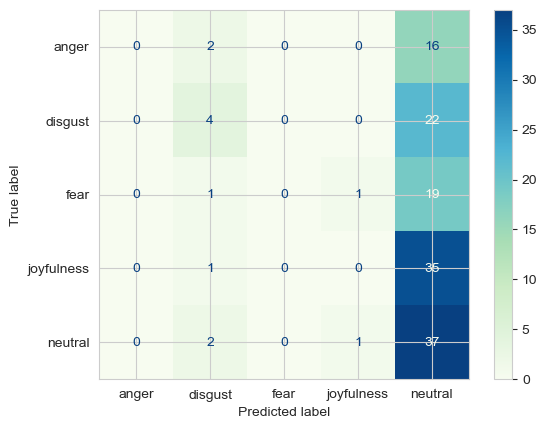

In [591]:
confusion_matrix(model)

### Вывод

In [592]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.32
val_PR_AUC: 0.27


In [593]:
# сохраним данные о модели
model_31 = model
hist_31 = hist

In [594]:
stat_3['1_layer_1024'] = model_best_results[1]

In [596]:
stat_3

{'1_layer_1024': 0.27}

## <b>Модель 3.2 | SGD 1024 нейронов</b>

### Архитектура модели

In [597]:
strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1024, activation='relu'),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER
                                 )

], name='SGD_cat_crossentropy')

model.summary()

Model: "SGD_cat_crossentropy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_270 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_193 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_271 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_194 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                        

In [598]:
len(model.trainable_variables)

16

### Компиляция

In [599]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

### Обучение модели

In [600]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 34s 867ms/step - loss: 5.4588 - accuracy: 0.2241 - PR_AUC: 0.2210 - val_loss: 3.9941 - val_accuracy: 0.2453 - val_PR_AUC: 0.2381 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 31s 900ms/step - loss: 3.4069 - accuracy: 0.2574 - PR_AUC: 0.2477 - val_loss: 2.7763 - val_accuracy: 0.2390 - val_PR_AUC: 0.2447 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 34s 998ms/step - loss: 2.4747 - accuracy: 0.2657 - PR_AUC: 0.2654 - val_loss: 2.1919 - val_accuracy: 0.2642 - val_PR_AUC: 0.2431 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 28s 824ms/step - loss: 2.0223 - accuracy: 0.2759 - PR_AUC: 0.2757 - val_loss: 1.9048 - val_accuracy: 0.2264 - val_PR_AUC: 0.2346 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 27s 798ms/step - loss: 1.8012 - accuracy: 0.2852 - PR_AUC: 0.2858 - val_loss: 1.7581 - val_accuracy: 0.2390 - val_PR_AUC: 0.2276 - lr: 0.0100
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

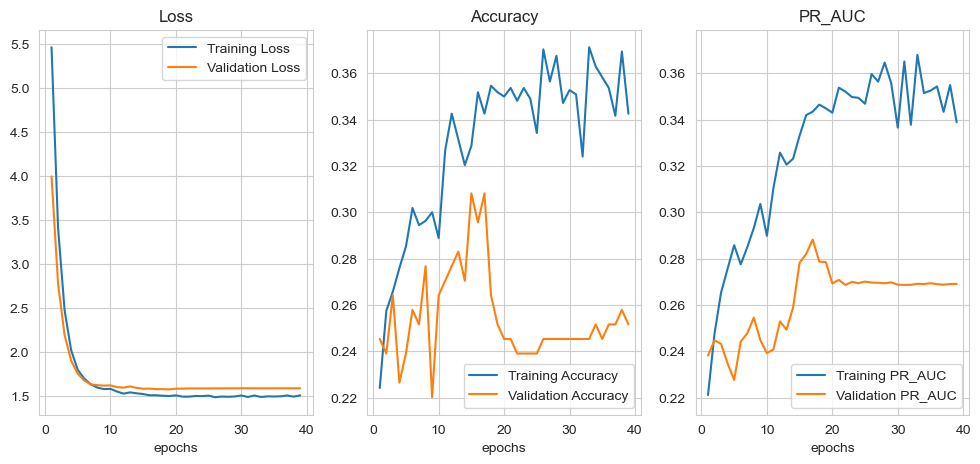

In [601]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [602]:
show_predictions(model, visualization=False)

neutral is joyfulness (25.89%)
joyfulness is joyfulness (25.84%)
neutral is joyfulness (30.97%)
disgust is disgust (34.32%)
joyfulness is neutral (25.35%)
disgust is fear (30.97%)
anger is fear (27.86%)
neutral is joyfulness (28.11%)
neutral is joyfulness (30.43%)
neutral is neutral (26.82%)


### Матрица ошибок

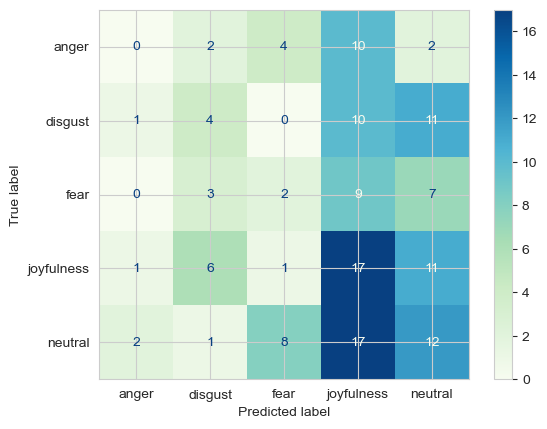

In [603]:
confusion_matrix(model)

### Вывод

In [604]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.29


In [605]:
# сохраним данные о модели
model_32 = model
hist_32 = hist

In [606]:
stat_3['SGD 1_layer_1024'] = model_best_results[1]

In [607]:
stat_3

{'1_layer_1024': 0.27, 'SGD 1_layer_1024': 0.29}

## <b>Модель 3.3 | SGD 1024 нейронов L2=2</b>

### Архитектура модели

In [622]:
strides = 2
REGULARIZER_1=tf.keras.regularizers.L1L2(l1=0.0, l2=2.0)
REGULARIZER_2=tf.keras.regularizers.L1L2(l1=0.0, l2=0.0)


model = tf.keras.Sequential([

            rescale,
            data_aug,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),
    
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1024, activation='relu',
                                 kernel_regularizer=REGULARIZER_2
                                 ),
    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_regularizer=REGULARIZER_1
                                 )

], name='SGD_cat_crossentropy')

model.summary()

Model: "SGD_cat_crossentropy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_290 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_208 (MaxPooli  (None, 56, 56, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_291 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_209 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                        

In [623]:
len(model.trainable_variables)

16

### Компиляция

In [624]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

### Обучение модели

In [625]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 32s 807ms/step - loss: 8.6586 - accuracy: 0.2259 - PR_AUC: 0.2201 - val_loss: 2.8161 - val_accuracy: 0.2893 - val_PR_AUC: 0.2680 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 27s 806ms/step - loss: 2.0375 - accuracy: 0.2704 - PR_AUC: 0.2577 - val_loss: 1.7186 - val_accuracy: 0.2327 - val_PR_AUC: 0.2601 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 30s 873ms/step - loss: 1.6425 - accuracy: 0.2907 - PR_AUC: 0.2704 - val_loss: 1.6415 - val_accuracy: 0.2390 - val_PR_AUC: 0.2508 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 31s 899ms/step - loss: 1.6131 - accuracy: 0.2870 - PR_AUC: 0.2753 - val_loss: 1.6336 - val_accuracy: 0.2516 - val_PR_AUC: 0.2530 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 27s 793ms/step - loss: 1.6080 - accuracy: 0.2972 - PR_AUC: 0.2757 - val_loss: 1.6296 - val_accuracy: 0.2893 - val_PR_AUC: 0.2550 - lr: 0.0100
Epoch 6/500
34/34 [======

KeyboardInterrupt: 

### Визуализация данных по работе алгоритма

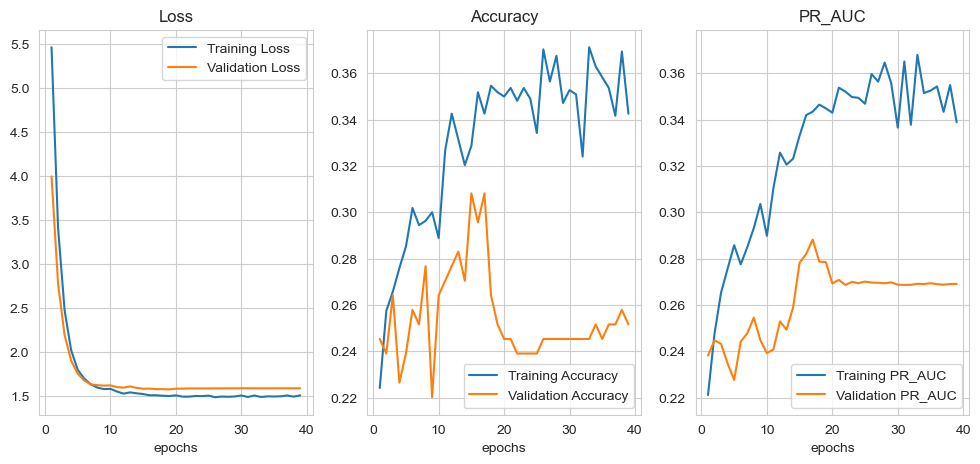

In [601]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [602]:
show_predictions(model, visualization=False)

neutral is joyfulness (25.89%)
joyfulness is joyfulness (25.84%)
neutral is joyfulness (30.97%)
disgust is disgust (34.32%)
joyfulness is neutral (25.35%)
disgust is fear (30.97%)
anger is fear (27.86%)
neutral is joyfulness (28.11%)
neutral is joyfulness (30.43%)
neutral is neutral (26.82%)


### Матрица ошибок

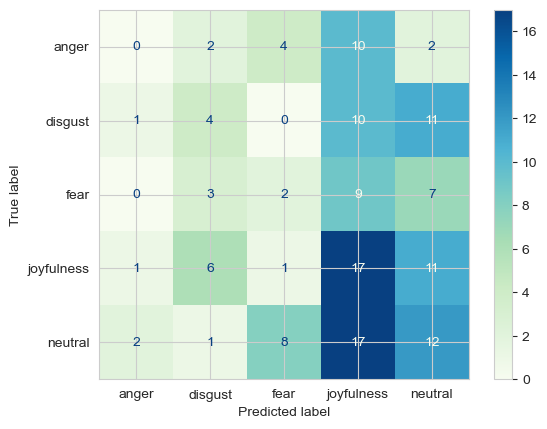

In [603]:
confusion_matrix(model)

### Вывод

In [604]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.29


In [605]:
# сохраним данные о модели
model_32 = model
hist_32 = hist

In [606]:
stat_3['SGD 1_layer_1024'] = model_best_results[1]

In [607]:
stat_3

{'1_layer_1024': 0.27, 'SGD 1_layer_1024': 0.29}

# <b>МОДЕЛЬ 1</b> | `Include_top`

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Создадим `feature_extractor`, который извлечет веса из предобученной модели `tensorflow` для переноса обучения на нашу модель. При переносе обучения рекомендуется отключать самые "верхние", то есть последние слои предобученной модели: именно в них происходит обучение на данную классификацию. Однако для начала мы проверим, как будут обучаться наши модели на полной предобученной модели `Mobile Net V2`.

Во втором блоке экспериментов мы отключим верхние слои, а в третьем пойдем еще дальше и разморозим часть слоев предобученной модели. За "разморозку" слоев у нас будет отвечать параметр `do_fine_tuning`, который может принимать только булевы значения (в первых двух блоках он установлен в режим `False`).

Итак, приступим к первому блоку экспериментов, используем предобученную модель "как есть". 

In [205]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: False.


## <b>Модель 1.1</b> | Baseline

Построим базовую последовательную модель, в которой у нас будут только слои `rescale`,  `feature_extractor` и слой предсказания.

### Архитектура модели

In [217]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([
            rescale,
            data_aug,
            feature_extractor,
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax')
], name='model_11')

model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dropout_22 (Dropout)        (None, 1000)              0         
                                                                 
 batch_normalization_34 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dense_42 (Dense)            (None, 64)                64064     
                                         

Проверим количество обучаемых параметров. Два означает - вектор значений весов (kernel) и вектор значений свободных членов (bias).

In [218]:
len(model.trainable_variables)

8

### Компиляция

В качестве оптимизатора во всех моделях неизменно будем использовать Adam, learning_rate установим базовый, он будет корректироваться как самим оптимизатором внутри эпохи, так и в начале каждой эпохи благодаря `lr_schedule` `callback`.

In [219]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

Модель скомпилирована, то есть все заданные параметры зафиксированы до следующей компиляции.

### Обучение модели

На стадии обучения модели зададим зафиксированное количество эпох (500), которое в процессе обучения будет автоматически оптимизировано соответствующим callback'ом. 

In [220]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule]
                )

Epoch 1/500
34/34 [==============================] - 57s 2s/step - loss: 1.8470 - accuracy: 0.2685 - PR_AUC: 0.2504 - val_loss: 1.5977 - val_accuracy: 0.2642 - val_PR_AUC: 0.2392 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 60s 2s/step - loss: 1.5336 - accuracy: 0.3593 - PR_AUC: 0.3581 - val_loss: 1.5869 - val_accuracy: 0.2453 - val_PR_AUC: 0.2615 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 50s 1s/step - loss: 1.3947 - accuracy: 0.4250 - PR_AUC: 0.4278 - val_loss: 1.5794 - val_accuracy: 0.2767 - val_PR_AUC: 0.2878 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 59s 2s/step - loss: 1.3417 - accuracy: 0.4417 - PR_AUC: 0.4667 - val_loss: 1.5709 - val_accuracy: 0.2642 - val_PR_AUC: 0.2875 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 52s 2s/step - loss: 1.2809 - accuracy: 0.4657 - PR_AUC: 0.5037 - val_loss: 1.5619 - val_accuracy: 0.3019 - val_PR_AUC: 0.2983 - lr: 0.0100
Epoch 6/500
34/34 [=====================

KeyboardInterrupt: 

### Визуализация данных по работе алгоритма

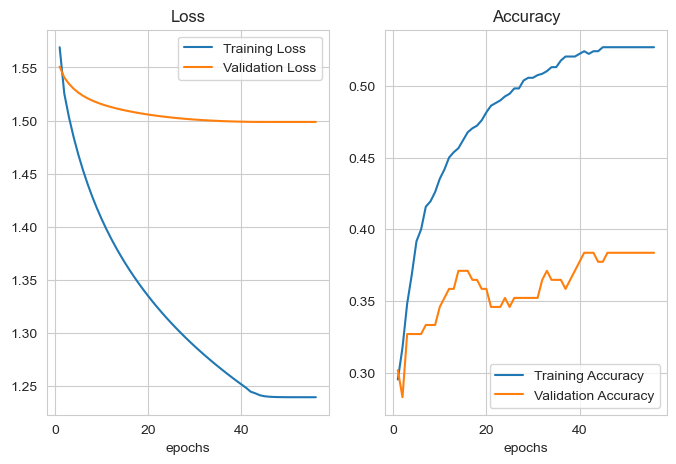

In [313]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

#### На изображениях из Сети

При желании качество работы модели можно проверить на реальных фотографиях экспертным методом. Для этого создадим новую папку, куда загрузим желаемые изображения. Далее, подготовленная функция преобразует изображения в необходимый для визуализации и предсказания формат. Оставим эту часть в качестве дополнения, использовать ее пока не будем.

In [ ]:
# from PIL import Image
# import numpy as np
# from tensorflow.keras.utils import load_img, img_to_array
# import os

# new_test_dir = Path('./data/test_images')
# Path.mkdir(new_test_dir)

# def show_predictions(model):
    
#     images = os.listdir(new_test_dir)
    
#     for i, img_path in enumerate(images):

#         # путь к тестовым изображениям
#         path = new_test_dir / img_path

#         # приведение изображений к желаемому разрешению
#         img = load_img(path, target_size=IMAGE_SIZE + (3,))
#         # перевод изображения в массив
#         x = img_to_array(img)

#         # добавление четвертого измерения для модели
#         images = np.expand_dims(x, axis=0)
        
#         plt.figure(figsize=(2, 2))
#         # Отключить оси
#         plt.axis(False)
#         plt.imshow(np.squeeze(images).astype('uint8'))
#         # plt.title(img_path)
#         plt.show()

#         # предсказание
#         classes = model.predict(images, batch_size=10)

#         class_pred = np.argmax(classes)
#         # print(np.argmax(class_pred))
#         print(f'{img_path} is {class_names[class_pred]} ({np.max(classes[0])*100:.2f}%)')
        
# show_predictions(model)

#### На изображениях из тестовой выборки

Посмотрим на то, как модель предсказывает тестовые изображения, хранящиеся в третьей, тестовой выборке, которая до этого момента не принимала участия в работе. Напомним, что тестовая выбора разбита на батчи по одному изображению, что позволяет нам проще контролировать количество изображений, которое мы хотим использовать для предсказания. Следующая функция покажет изображение, заданное и предсказанное значение класса, а также "уверенность" модели в своем предсказании. На данном этапе посмотрим на небольшое количество изображений (по умолчанию 10, можно изменить это число, задав соответствующий аргумент), а полную картину оценим дальше, построив матрицу ошибок.

In [ ]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

def show_predictions(model, image_set=test_batches,
                     images_number=10, visualization=False):

    images = image_set.take(images_number)

    for img, label in images:

        if visualization == True:
            plt.figure(figsize=(2, 2))
            # Отключить оси
            plt.axis(False)
            # оставим три измерения из четырех
            image = np.squeeze(img)
            plt.imshow(image.astype('uint8'))
            plt.show()

        # реальный класс
        label = np.argmax(label)
        # предсказанный класс
        prediction = model.predict(img)
        pred = np.argmax(prediction)

        print(f'{class_names[label]} is {class_names[pred]} ({np.max(prediction[0])*100:.2f}%)')

In [314]:
show_predictions(model, visualization=False)

neutral is disgust (30.62%)
neutral is neutral (70.08%)
neutral is neutral (93.90%)
fear is fear (56.81%)
joyfulness is joyfulness (35.87%)
joyfulness is joyfulness (29.68%)
anger is joyfulness (34.31%)
disgust is anger (24.19%)
neutral is neutral (57.09%)
fear is neutral (32.72%)


### Матрица ошибок

Напишем функцию для отображения матрицы ошибок, которая пригодится нам и в дальнейшем.

In [ ]:
def confusion_matrix(model, images_number=None, dataset=test_batches, class_names=class_names):

    '''
    Выводит матрицу ошибок на тестовых данных. 
    
    Аргументы:
    - model - обученная модель.
    - images_number - количество изображений из тестовой выборки;
            если None, то используются все изображения в выборке.
    - dataset - tf.dataset с тестовыми изображениями.
    '''
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    if images_number is None:
        test_images = dataset
    else:
        test_images = dataset.take(images_number)
        
    y_test, y_pred = ([np.argmax(y) for _, y in test_images], 
                      [np.argmax(x) for x in model.predict(test_images)])
        
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()

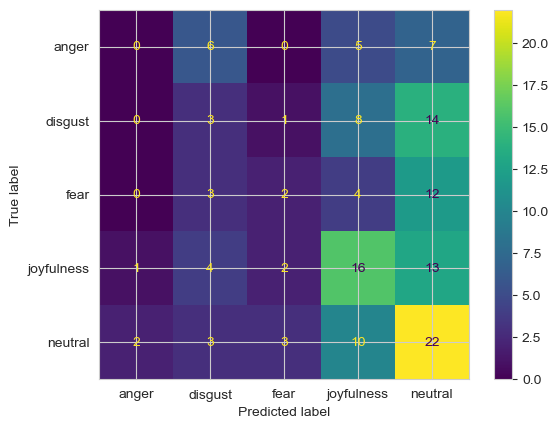

In [315]:
confusion_matrix(model)

### Вывод

Модель удивительно устойчива к переобучению без каких-либо дополнительных слоев, но при этом и к обучению она практически неспособна. Матрица ошибок показывает, что данная модель с трудом обучается отдельным классам.

Зафиксируем ее лучший показатель `val_accuracy` и попробуем улучшить модель.

In [316]:
val_acc_best = np.max(hist.history['val_accuracy'])
baseline_best_result = round(val_acc_best, 2)
baseline_best_result

0.38

In [317]:
# сохраним данные о модели
model_1_1 = model
hist_1_1 = hist

## <b>Модель 1.2</b> | Deeper baseline

Так как базовая модель очень устойчива к переобучению, но при этом обучается крайне медленно, есть смысл попробовать углубить модель (добавить полносвязных слоев) и расширить ее (увеличить количество обучаемых параметров в полносвязных слоях).

### Архитектура модели

In [ ]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([

            rescale,

            feature_extractor,

            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')

], name='deeper_baseline')

model.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model.summary()

In [ ]:
len(model.trainable_variables)

### Компиляция

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule]
                )

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model)

### Матрица ошибок

In [ ]:
confusion_matrix(model)

### Вывод

Модель очень быстро переобучилась, практически с первых эпох, при этом показатели удалось несколько улучшить. Анализ матрицы ошибок показывает, что лучше всего модель предсказывает класс `neutral`, что неудивительно, так как именно в данном классе у нас больше всего изображений. 

Зафиксируем лучший показатель `val_accuracy` и сохраним данные по результатам работы модели в отдельные переменные на случай, если потребуется к ним снова обратиться.

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
model_1_2_best_result = round(val_acc_best, 2)
model_1_2_best_result

In [ ]:
# сохраним данные о модели
model_1_2 = model
hist_1_2 = hist

## <b>Модель 1.3</b> | Dropout и BatchNormalization layers

Доработаем предыдущую модель, добавив в ее архитектуру аугментацию данных и слои батч-нормализации и `dropout`. Это позволит нам отложить момент переобучения.

### Архитектура модели

In [ ]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([

            rescale,
            data_aug,

            feature_extractor,

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512, activation='relu'),

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1024, activation='relu'),

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1024, activation='relu'),

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax')

], name='deeper_DropOut_BN_baseline')

model.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model.summary()

In [ ]:
len(model.trainable_variables)

### Компиляция

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule]
                )

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model)

### Матрица ошибок

In [ ]:
confusion_matrix(model)

### Вывод

Модель очень быстро переобучилась, практически с первых эпох, при этом и ее предсказательная способность значительно выросла. Анализ матрицы ошибок показывает, что лучше всего модель предсказывает класс `neutral`, что неудивительно, так как именно в данном классе у нас больше всего изображений. Зафиксируем лучший показатель `val_accuracy` и сохраним данные по результатам работы модели в отдельные переменные на случай, если потребуется к ним снова обратиться.

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
model_1_3_best_result = round(val_acc_best, 2)
model_1_3_best_result

In [ ]:
# сохраним данные о модели
model_1_3 = model
hist_1_3 = hist

# <b>МОДЕЛЬ 2</b> | Bottleneck

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Во втором блоке экспериментов будем работать с предобученной моделью, у которой отключены самые верхние слои на классификацию, цель: дообучить собственный классификатор. 

Выбрав опцию `include_top=False` мы оставляем для нашей модели все слои до самого последнего перед слоем `Flatten` предобученной модели (в литературе его называют слоем "бутылочным горлышком" - "bottleneck layer"), туда мы поместим наши собственные полносвязные слои, которые в предыдущем блоки шли за полной предуобченной моделью. Признаки, содержащиеся в "бутылочном горлышке", представляют наибольшую ценность, так как именно они содержат самые  общие признаки изображений (в отличие от более специфичных признаков для конкретных классов в верхних слоях).

In [336]:
do_fine_tuning = False
feature_extractor_bottleneck = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor_bottleneck.trainable = do_fine_tuning

## <b>Модель 2.1</b> | Bottleneck baseline

### Архитектура модели

Добавим слой `Flatten`, который мы исключаем из предобученной модели, чтобы перевести матрицы изображений в векторный вид (либо можно активировать аттрибут `pooling` внутри самого `feature_extractor`), другие слои пока добавлять не будем.

In [238]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

strides = 2

model = tf.keras.Sequential([

            rescale,
            data_aug,

            feature_extractor_bottleneck,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=REGULARIZER,
                                  bias_regularizer=REGULARIZER),

            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                  kernel_regularizer=REGULARIZER,
                                  bias_regularizer=REGULARIZER)

], name='bottleneck_baseline')

model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "bottleneck_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_95 (Conv2D)          (None, 4, 4, 32)          368672    
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                              

In [239]:
len(model.trainable_variables)

12

### Компиляция

In [240]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

### Обучение модели

In [241]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 76s 2s/step - loss: 7.4646 - accuracy: 0.2741 - PR_AUC: 0.2606 - val_loss: 7.1673 - val_accuracy: 0.2956 - val_PR_AUC: 0.3058 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 74s 2s/step - loss: 6.8861 - accuracy: 0.3352 - PR_AUC: 0.3418 - val_loss: 6.8597 - val_accuracy: 0.3019 - val_PR_AUC: 0.3263 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 58s 2s/step - loss: 6.5697 - accuracy: 0.3824 - PR_AUC: 0.3715 - val_loss: 6.4049 - val_accuracy: 0.3711 - val_PR_AUC: 0.3284 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 60s 2s/step - loss: 6.1660 - accuracy: 0.4463 - PR_AUC: 0.4704 - val_loss: 6.1635 - val_accuracy: 0.4151 - val_PR_AUC: 0.4091 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 57s 2s/step - loss: 5.9048 - accuracy: 0.4833 - PR_AUC: 0.5098 - val_loss: 5.9729 - val_accuracy: 0.3962 - val_PR_AUC: 0.3864 - lr: 0.0100
Epoch 6/500
34/34 [=====================

### Визуализация данных по работе алгоритма

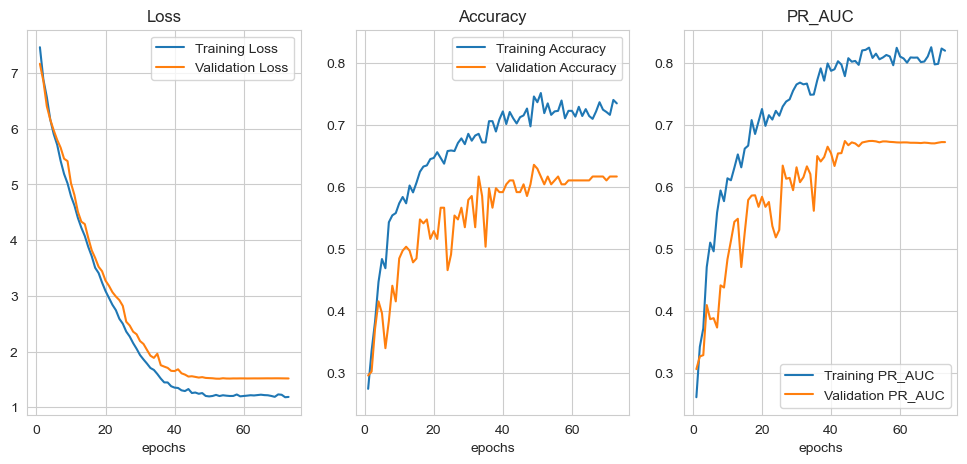

In [242]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [223]:
show_predictions(model)

joyfulness is joyfulness (57.78%)
neutral is neutral (51.43%)
anger is joyfulness (25.68%)
neutral is neutral (51.19%)
neutral is neutral (51.59%)
fear is neutral (52.27%)
neutral is neutral (51.88%)
anger is disgust (23.27%)
neutral is neutral (50.40%)
disgust is neutral (52.23%)


### Матрица ошибок

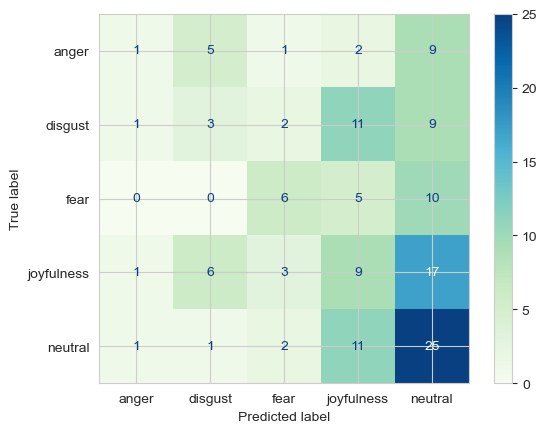

In [245]:
confusion_matrix(model)

### Вывод

Модель очень быстро переобучилась, практически с первых эпох, при этом и ее предсказательная способность значительно выросла. Анализ матрицы ошибок показывает, что лучше всего модель предсказывает класс `neutral`, что неудивительно, так как именно в данном классе у нас больше всего изображений. Зафиксируем лучший показатель `val_accuracy` и сохраним данные по результатам работы модели в отдельные переменные на случай, если потребуется к ним снова обратиться.

In [249]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_21_best_result = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_21_best_result[0]}')
print(f'val_PR_AUC: {model_21_best_result[1]}')

val_accuracy: 0.64
val_PR_AUC: 0.67


In [250]:
# сохраним данные о модели
model_21 = model
hist_21 = hist

## <b>Модель 2.2</b> | Bottleneck baseline cont

### Архитектура модели

Добавим слой `Flatten`, который мы исключаем из предобученной модели, чтобы перевести матрицы изображений в векторный вид (либо можно активировать аттрибут `pooling` внутри самого `feature_extractor`), другие слои пока добавлять не будем.

In [338]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

strides = 1

model = tf.keras.Sequential([

            rescale,
            data_aug,

            feature_extractor_bottleneck,

            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),

            # tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=REGULARIZER,
                                  # bias_regularizer=REGULARIZER
                                 ),

            # tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=REGULARIZER,
                                  # bias_regularizer=REGULARIZER
                                 ),

            # tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=REGULARIZER,
                                  # bias_regularizer=REGULARIZER
                                 ),

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                  kernel_regularizer=REGULARIZER,
                                  # bias_regularizer=REGULARIZER
                                 )

], name='bottleneck_baseline_cont')

model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "bottleneck_baseline_cont"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_136 (Conv2D)         (None, 4, 4, 32)          368672    
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                         

In [339]:
len(model.trainable_variables)

20

### Компиляция

In [340]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

### Обучение модели

In [341]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 71s 2s/step - loss: 24.5112 - accuracy: 0.2333 - PR_AUC: 0.2259 - val_loss: 24.0953 - val_accuracy: 0.2642 - val_PR_AUC: 0.2258 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 72s 2s/step - loss: 23.1053 - accuracy: 0.3306 - PR_AUC: 0.2992 - val_loss: 23.0195 - val_accuracy: 0.3333 - val_PR_AUC: 0.2883 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 65s 2s/step - loss: 21.8812 - accuracy: 0.3602 - PR_AUC: 0.3500 - val_loss: 21.3945 - val_accuracy: 0.3019 - val_PR_AUC: 0.2826 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 72s 2s/step - loss: 20.7400 - accuracy: 0.4009 - PR_AUC: 0.3878 - val_loss: 20.1726 - val_accuracy: 0.4340 - val_PR_AUC: 0.3979 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 76s 2s/step - loss: 19.6573 - accuracy: 0.4269 - PR_AUC: 0.4230 - val_loss: 19.2019 - val_accuracy: 0.3648 - val_PR_AUC: 0.3995 - lr: 0.0100
Epoch 6/500
34/34 [===========

KeyboardInterrupt: 

### Визуализация данных по работе алгоритма

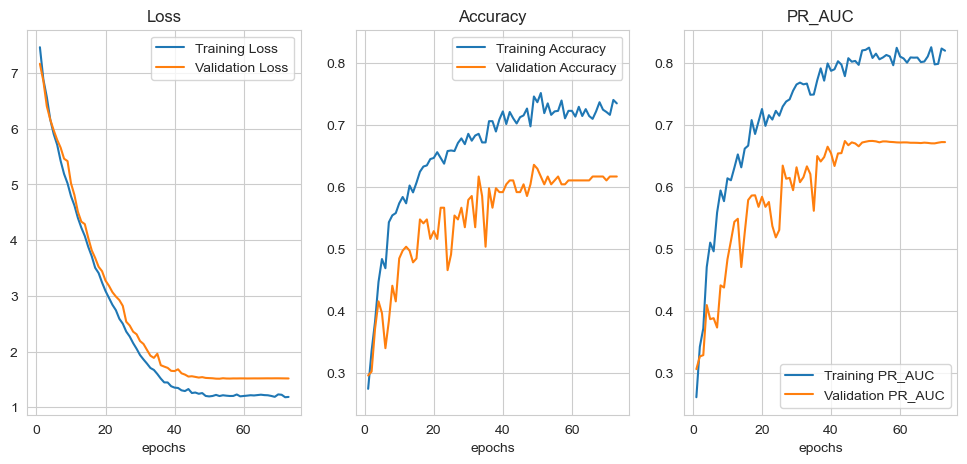

In [242]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [223]:
show_predictions(model)

joyfulness is joyfulness (57.78%)
neutral is neutral (51.43%)
anger is joyfulness (25.68%)
neutral is neutral (51.19%)
neutral is neutral (51.59%)
fear is neutral (52.27%)
neutral is neutral (51.88%)
anger is disgust (23.27%)
neutral is neutral (50.40%)
disgust is neutral (52.23%)


### Матрица ошибок

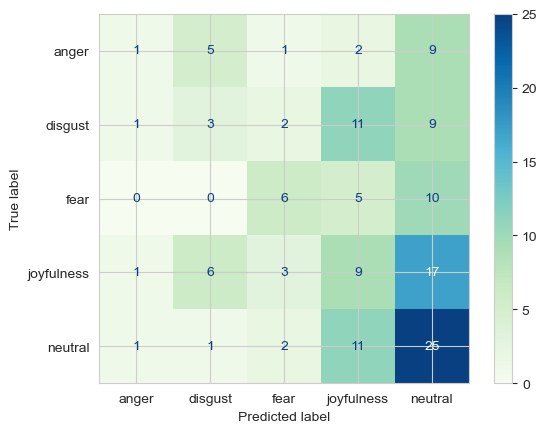

In [245]:
confusion_matrix(model)

### Вывод

Модель очень быстро переобучилась, практически с первых эпох, при этом и ее предсказательная способность значительно выросла. Анализ матрицы ошибок показывает, что лучше всего модель предсказывает класс `neutral`, что неудивительно, так как именно в данном классе у нас больше всего изображений. Зафиксируем лучший показатель `val_accuracy` и сохраним данные по результатам работы модели в отдельные переменные на случай, если потребуется к ним снова обратиться.

In [249]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_21_best_result = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_21_best_result[0]}')
print(f'val_PR_AUC: {model_21_best_result[1]}')

val_accuracy: 0.64
val_PR_AUC: 0.67


In [250]:
# сохраним данные о модели
model_21 = model
hist_21 = hist

## <b>Модель 2.2</b> | `fine_tuning`

На следующем шаге проверим эту же модель, но разморозим часть слоев предобученной модели. В официальных документах указано, что размораживать слои следует только после того, как мы уже обучили собственный классификатор, в ином случае предобученная модель с установленными в случайном порядке весами для новых слоев при обновлении весов потеряет все, чему она была обучена.

Кроме того, нет необходимости в разморозке "нижних слоев", так как они обнаруживают самые простые и общие закономерности, характерные для любых изображений. Цель применения предобученной модели - использовать более "специализированные" слои для дообучения новой модели на новом датасете, поэтому возьмем сравнительно небольшое число "верхних" слоев.

Особого внимания в случае разморозки `feature_extractor` заслуживают слои bacth normalization (`BN`). Это единственные встроенные слои, веса которых не должны обновляться при градиентном спуске, так как эти веса - движущиеся среднее значение и стандартное отклонение для нормализации текущего батча. Запустив модель в режиме `trainable=False`, мы эти слои заморозили. Когда мы на следующем шаге размораживаем всю модель или ее часть, слои BN продолжают работать в режиме inference (движущиеся mean и std), а не обучения (mean и std текущего батча). Это очень важный момент, так как если мы запустим `feature_extractor` сразу в режиме разморозки без предварительного обучения на замороженных слоях (то есть не заморозим веса BN), слои BN будут давать непредсказуемый результат (подробнее о проблеме [здесь](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)).

## Модуль `tf.keras.applications` | `feature_extractor_layer`

In [327]:
do_fine_tuning = True
feature_extractor_bottleneck = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor_bottleneck.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


Посмотрим на количество слоев в предобученной модели:

In [328]:
print("Number of layers in the feature extractor: ", len(feature_extractor_bottleneck.layers))

Number of layers in the feature extractor:  154


In [329]:
# с какого слоя мы размораживаем модель
fine_tune_at = 100

# Заморозим все остальные слои
for layer in feature_extractor_bottleneck.layers[:fine_tune_at]:
    layer.trainable = False

print("Trainable layers in the feature extractor: ", len(feature_extractor_bottleneck.trainable_variables))

Trainable layers in the feature extractor:  54


In [330]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

strides = 1

model = tf.keras.Sequential([

            rescale,
            # data_aug,

            feature_extractor_bottleneck,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dropout(DROPOUT_RATE*2),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dense(64, activation='relu',
            #                       kernel_regularizer=REGULARIZER,
            #                       bias_regularizer=REGULARIZER),

            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                  kernel_regularizer=REGULARIZER,
                                  # bias_regularizer=REGULARIZER
                                 )

], name='bottleneck_baseline_cont')

model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: True.

Model: "bottleneck_baseline_cont"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_134 (Conv2D)         (None, 4, 4, 32)          368672    
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_135 (Conv2D)         (None, 2, 2, 64)          18496     
                          

## Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены.

In [331]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

## Архитектура модели

In [332]:
model.summary()

Model: "bottleneck_baseline_cont"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_134 (Conv2D)         (None, 4, 4, 32)          368672    
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_135 (Conv2D)         (None, 2, 2, 64)          18496     
                                                                 
 flatten_51 (Flatten)        (None, 256)  

In [333]:
len(model.trainable_variables)

62

## Обучение модели

In [334]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 102s 3s/step - loss: 21.6522 - accuracy: 0.2759 - PR_AUC: 0.2661 - val_loss: 8.2551 - val_accuracy: 0.3145 - val_PR_AUC: 0.2779 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 76s 2s/step - loss: 8.1061 - accuracy: 0.3556 - PR_AUC: 0.3587 - val_loss: 8.2091 - val_accuracy: 0.2704 - val_PR_AUC: 0.2421 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 96s 3s/step - loss: 8.0931 - accuracy: 0.4259 - PR_AUC: 0.4157 - val_loss: 8.1059 - val_accuracy: 0.3333 - val_PR_AUC: 0.2760 - lr: 0.0100


KeyboardInterrupt: 

# <b>МОДЕЛЬ 3</b> | `fine_tuning`

# <b>Модель 3.1</b> | Pretrained baseline

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Попробуем предолеть проблему переобучения, добавив к предыдущей архитектуре слои с аугментацией данных, которые мы подготовили заранее. Другие параметры оставим нетронутыми. Обратим внимание, что мы создаем новую модель, а не дообучаем предыдущую (дообучением мы займемся позже).

In [659]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

In [697]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNet(
                                                input_shape=IMG_SHAPE,
                                                # alpha=1.0,
                                                # depth_multiplier=1,
                                                dropout=DROPOUT_RATE,
                                                include_top=False,
                                                weights="imagenet",
                                                # input_tensor=None,
                                                # pooling=None,
                                                # classes=1000,
                                                classifier_activation='softmax',
                                                # **kwargs
)
feature_extractor.trainable = do_fine_tuning

In [687]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.InceptionV3(
                                                include_top=False,
                                                weights="imagenet",
                                                # input_tensor=None,
                                                input_shape=IMG_SHAPE,
                                                # pooling=None,
                                                # classes=1000,
                                                # classifier_activation="softmax",
)
feature_extractor.trainable = do_fine_tuning

In [739]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.InceptionResNetV2(
                                                include_top=False,
                                                weights="imagenet",
                                                # input_tensor=None,
                                                input_shape=IMG_SHAPE,
                                                # pooling=None,
                                                # classes=1000,
                                                # classifier_activation="softmax",
                                                # **kwargs
)
feature_extractor.trainable = do_fine_tuning

In [688]:
# feature_extractor.summary()

## Архитектура модели

In [740]:
image_batch, label_batch = next(iter(train_batches))
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1536)


In [741]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [742]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax',
                                  kernel_regularizer=REGULARIZER
                                 )
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [743]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = rescale(inputs)
x = data_aug(x)
x = feature_extractor(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_8   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_112 (Dropout)       (None, 1536)              0   

In [682]:
# print(f'Строим модель на базе {MODULE_HANDLE}.')
# print(f'Разморозка слоев: {do_fine_tuning}.\n')

# strides = 1
# REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

# model = tf.keras.Sequential([

#             rescale,
#             data_aug,

#             feature_extractor,

#             # tf.keras.layers.Conv2D(32, (3, 3), padding="same",
#             #                    strides=strides, activation='relu'),
#             # tf.keras.layers.MaxPooling2D((2, 2)),
#             # tf.keras.layers.Conv2D(64, (3, 3), padding="same",
#             #                    strides=strides, activation='relu'),

#             tf.keras.layers.Flatten(),
#             tf.keras.layers.Dropout(DROPOUT_RATE),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dense(num_classes, activation='softmax',
#                                   kernel_regularizer=REGULARIZER
#                                  )

# ], name='pretrained_baseline')

# model.summary()

In [711]:
len(model.trainable_variables)

2

## Компиляция

In [744]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

## Обучение модели

In [745]:
hist = model.fit(train_batches,
                 epochs=1,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

34/34 [==============================] - 596s 17s/step - loss: 0.5878 - accuracy: 0.2065 - PR_AUC: 0.2008 - val_loss: 0.4632 - val_accuracy: 0.1258 - val_PR_AUC: 0.1798 - lr: 0.0100


### Визуализация данных по работе алгоритма

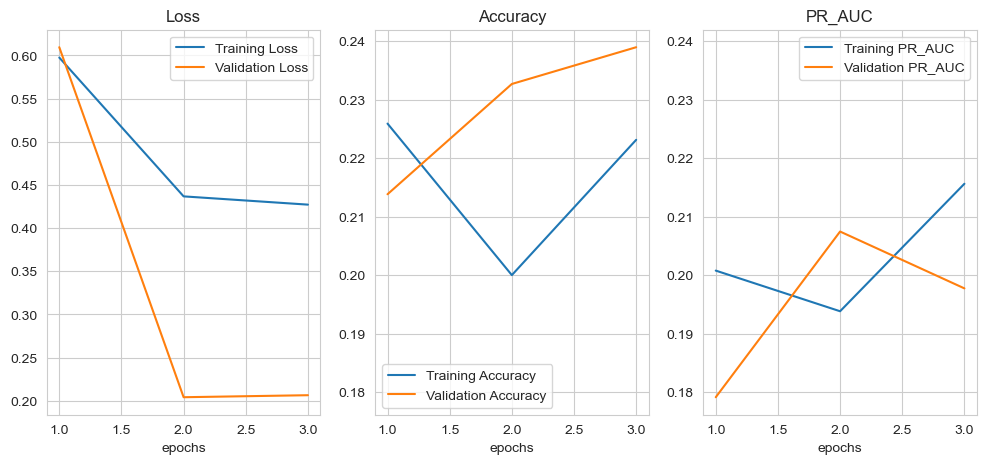

In [722]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [602]:
show_predictions(model, visualization=False)

neutral is joyfulness (25.89%)
joyfulness is joyfulness (25.84%)
neutral is joyfulness (30.97%)
disgust is disgust (34.32%)
joyfulness is neutral (25.35%)
disgust is fear (30.97%)
anger is fear (27.86%)
neutral is joyfulness (28.11%)
neutral is joyfulness (30.43%)
neutral is neutral (26.82%)


### Матрица ошибок

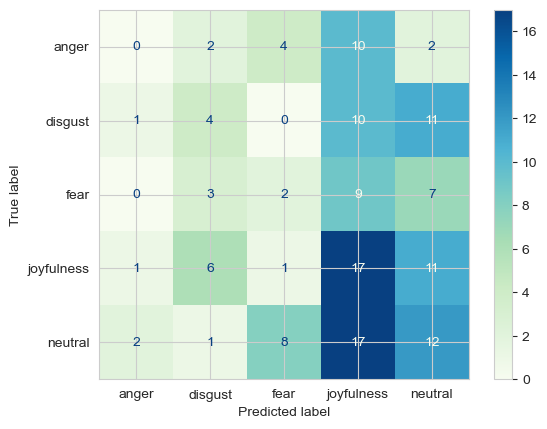

In [603]:
confusion_matrix(model)

### Вывод

In [604]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.29


In [724]:
# сохраним данные о модели
model_pretrained = model
hist_pretrained = hist

In [606]:
# stat_3['SGD 1_layer_1024'] = model_best_results[1]

In [607]:
# stat_3

{'1_layer_1024': 0.27, 'SGD 1_layer_1024': 0.29}

## Разморозка слоев

In [746]:
do_fine_tuning = True
# feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


Посмотрим на количество слоев в предобученной модели:

In [736]:
# с какого слоя мы размораживаем модель
fine_tune_at = 1

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at]:
    layer.trainable = False

In [747]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable layers in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  780
Trainable layers in the feature extractor:  488


## Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены.

In [748]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='mse',
              metrics=metrics)

## Архитектура модели

In [749]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_8   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_112 (Dropout)       (None, 1536)              0   

In [750]:
len(model.trainable_variables)

490

## Обучение

In [751]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
 3/34 [=>............................] - ETA: 49:09 - loss: 0.4828 - accuracy: 0.1250 - PR_AUC: 0.1769  


KeyboardInterrupt



### Визуализация данных по работе алгоритма

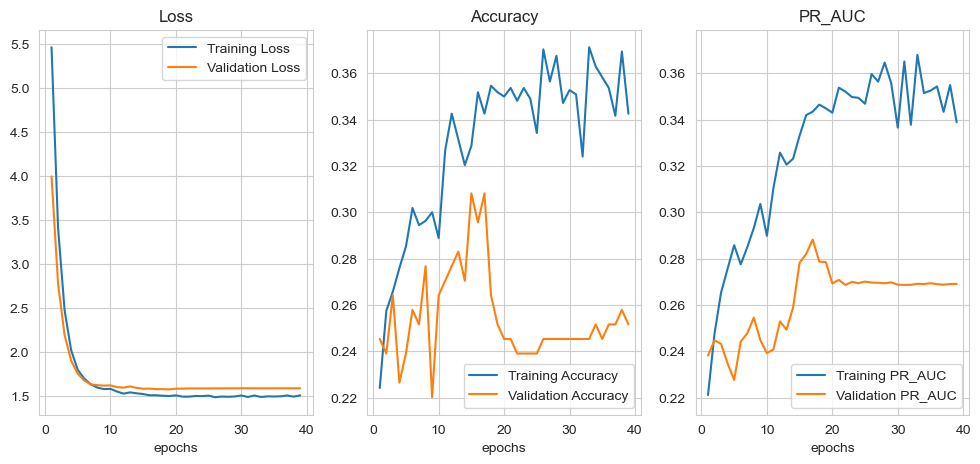

In [601]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [602]:
show_predictions(model, visualization=False)

neutral is joyfulness (25.89%)
joyfulness is joyfulness (25.84%)
neutral is joyfulness (30.97%)
disgust is disgust (34.32%)
joyfulness is neutral (25.35%)
disgust is fear (30.97%)
anger is fear (27.86%)
neutral is joyfulness (28.11%)
neutral is joyfulness (30.43%)
neutral is neutral (26.82%)


### Матрица ошибок

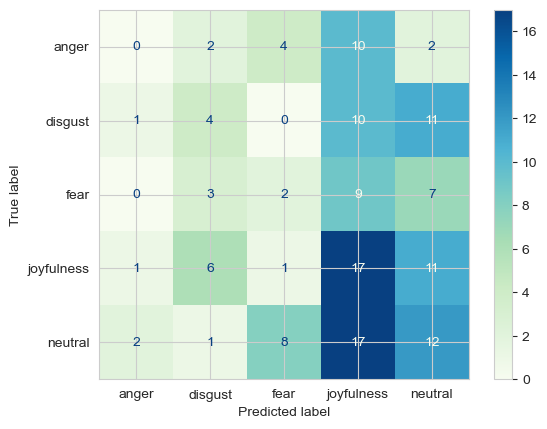

In [603]:
confusion_matrix(model)

### Вывод

In [604]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.29


In [605]:
# сохраним данные о модели
model_32 = model
hist_32 = hist

In [606]:
stat_3['SGD 1_layer_1024'] = model_best_results[1]

In [607]:
stat_3

{'1_layer_1024': 0.27, 'SGD 1_layer_1024': 0.29}

# <b>Модель 4</b> | Слои свертки

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Дополним существующую архитектуру слоями свертки и сжатия изображений и посмотрим, насколько изменится результат. Также добавим слои `dropout` и `batchnormalization`.

In [152]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               # classes=num_classes
                                                     )
feature_extractor.trainable = do_fine_tuning

## Архитектура модели

In [180]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([

            rescale,
            data_aug,

            feature_extractor,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=2, activation='relu'),
            # tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax')

], name='convnet_model')

model.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "convnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 32)          368672    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                    

In [181]:
len(model.trainable_variables)

8

## Компиляция

In [182]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Обучение модели

In [183]:
EPOCHS = 15

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/15
34/34 [==============================] - 71s 2s/step - loss: 1.7079 - accuracy: 0.3296 - val_loss: 2.2441 - val_accuracy: 0.2893
Epoch 2/15
34/34 [==============================] - 58s 2s/step - loss: 1.4723 - accuracy: 0.4176 - val_loss: 1.8625 - val_accuracy: 0.2642
Epoch 3/15
34/34 [==============================] - 60s 2s/step - loss: 1.2983 - accuracy: 0.4935 - val_loss: 1.4661 - val_accuracy: 0.3899
Epoch 4/15
34/34 [==============================] - 57s 2s/step - loss: 1.1978 - accuracy: 0.5231 - val_loss: 1.3851 - val_accuracy: 0.4654
Epoch 5/15
34/34 [==============================] - 60s 2s/step - loss: 1.1289 - accuracy: 0.5565 - val_loss: 1.6501 - val_accuracy: 0.4151
Epoch 6/15
34/34 [==============================] - 57s 2s/step - loss: 1.0881 - accuracy: 0.5769 - val_loss: 1.3348 - val_accuracy: 0.4277
Epoch 7/15
34/34 [==============================] - 70s 2s/step - loss: 1.0678 - accuracy: 0.6083 - val_loss: 1.9261 - val_accuracy: 0.2956
Epoch 8/15
34/34 [==

## Визуализация данных по работе алгоритма

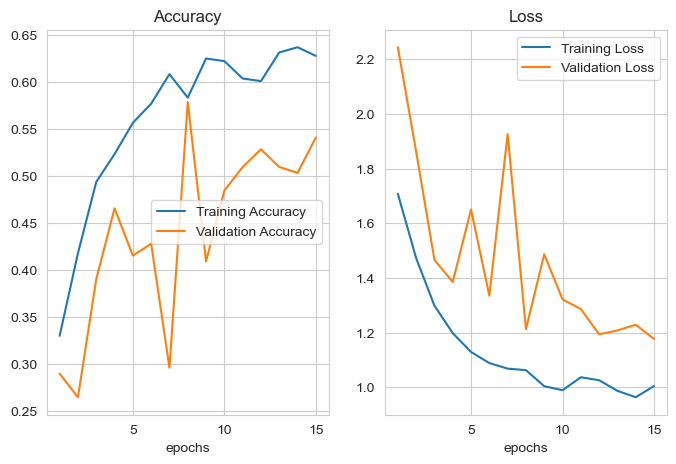

In [184]:
val_acc_viz(hist, EPOCHS)

## Предсказание модели

In [185]:
show_predictions(model)

joyfulness is joyfulness (50.46%)
anger is disgust (28.32%)
disgust is neutral (73.14%)
neutral is neutral (65.20%)
disgust is joyfulness (46.75%)
neutral is neutral (43.82%)
anger is joyfulness (46.27%)
neutral is neutral (62.26%)
neutral is neutral (75.10%)
neutral is neutral (59.74%)


## Матрица ошибок

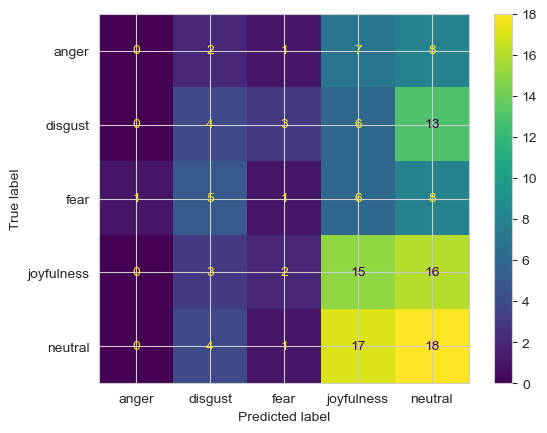

In [186]:
confusion_matrix(model)

## Вывод

Модель по-прежнему отрабатывает плохо - переобучение наступает до 10-й эпохи, предсказательная способность остается даже ниже, чем у второй модели. Продолжаем эксперимент. 

In [187]:
val_acc_best = np.max(hist.history['val_accuracy'])
model_4_best_result = round(val_acc_best, 2)
model_4_best_result

0.58

In [188]:
# сохраним данные о модели
model_4 = model
hist_4 = hist

# <b>Модель 5</b> | Больше слоёв классификатора

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Попробуем пойти вглубь и добавить полносвязных слоев.

In [131]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=num_classes)
feature_extractor.trainable = do_fine_tuning

## Архитектура модели

In [132]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([

            rescale,
            data_aug,

            feature_extractor,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=1, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=1, activation='relu'),

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512, activation='relu'),

            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512, activation='relu'),

            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax')

], name='convnet__wider_model')

model.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "convnet__wider_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 32)          368672    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                             

In [133]:
len(model.trainable_variables)

16

## Компиляция

In [134]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Обучение модели

In [135]:
EPOCHS = 15

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/15
34/34 [==============================] - 71s 2s/step - loss: 2.1642 - accuracy: 0.2481 - val_loss: 1.8232 - val_accuracy: 0.3459
Epoch 2/15
34/34 [==============================] - 54s 2s/step - loss: 1.9446 - accuracy: 0.2963 - val_loss: 2.3612 - val_accuracy: 0.2516
Epoch 3/15
34/34 [==============================] - 61s 2s/step - loss: 1.7900 - accuracy: 0.3611 - val_loss: 2.0003 - val_accuracy: 0.2956
Epoch 4/15
34/34 [==============================] - 54s 2s/step - loss: 1.6719 - accuracy: 0.3926 - val_loss: 2.0597 - val_accuracy: 0.2956
Epoch 5/15
34/34 [==============================] - 61s 2s/step - loss: 1.5167 - accuracy: 0.4481 - val_loss: 1.5672 - val_accuracy: 0.3899
Epoch 6/15
34/34 [==============================] - 56s 2s/step - loss: 1.4289 - accuracy: 0.4528 - val_loss: 1.6072 - val_accuracy: 0.4151
Epoch 7/15
34/34 [==============================] - 58s 2s/step - loss: 1.3578 - accuracy: 0.4954 - val_loss: 2.0347 - val_accuracy: 0.3145
Epoch 8/15
34/34 [==

## Визуализация данных по работе алгоритма

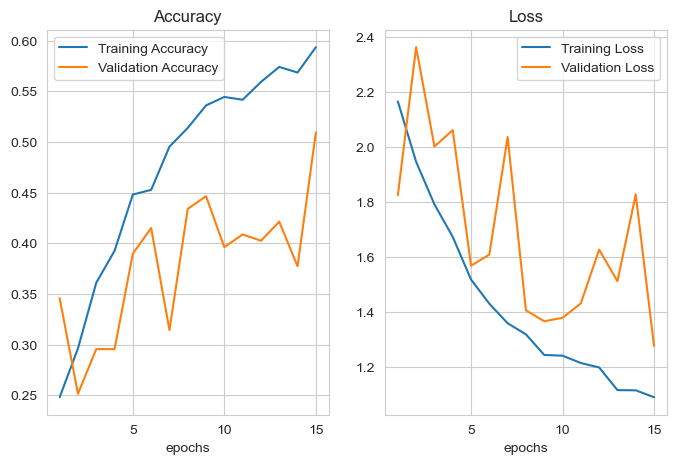

In [136]:
val_acc_viz(hist, EPOCHS)

## Предсказание модели

In [137]:
show_predictions(model)

neutral is neutral (82.95%)
joyfulness is disgust (34.02%)
neutral is neutral (84.58%)
neutral is neutral (80.06%)
neutral is fear (49.44%)
fear is fear (87.75%)
neutral is neutral (62.91%)
disgust is neutral (39.37%)
fear is neutral (53.79%)
disgust is neutral (74.56%)


## Матрица ошибок

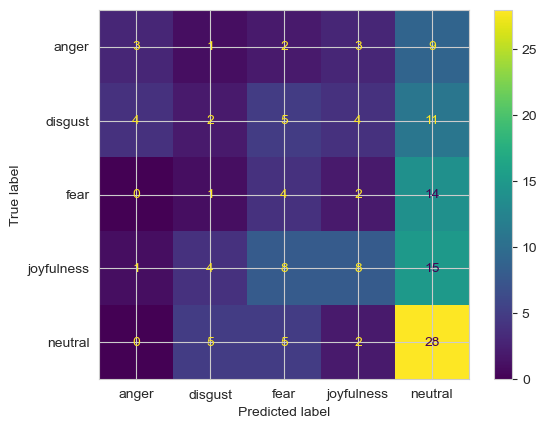

In [138]:
confusion_matrix(model)

## Вывод

Модель по-прежнему отрабатывает плохо - переобучение наступает до 10-й эпохи, предсказательная способность остается даже ниже, чем у второй модели. Продолжаем эксперимент. 

In [139]:
val_acc_best = np.max(hist.history['val_accuracy'])
model_5_best_result = round(val_acc_best, 2)
model_5_best_result

0.51

In [140]:
# сохраним данные о модели
model_5 = model
hist_5 = hist

# <b>Модель 6</b> | `fine_tuning`

## Модуль `tf.keras.applications` | `feature_extractor_layer`

На следующем шаге проверим эту же модель, но разморозим часть слоев предобученной модели. В официальных документах указано, что размораживать слои следует только после того, как мы уже обучили собственный классификатор, в ином случае предобученная модель с установленными в случайном порядке весами для новых слоев при обновлении весов потеряет все, чему она была обучена.

Кроме того, нет необходимости в разморозке "нижних слоев", так как они обнаруживают самые простые и общие закономерности, характерные для любых изображений. Цель применения предобученной модели - использовать более "специализированные" слои для дообучения новой модели на новом датасете, поэтому возьмем сравнительно небольшое число "верхних" слоев.

Особого внимания в случае разморозки `feature_extractor` заслуживают слои bacth normalization (`BN`). Это единственные встроенные слои, веса которых не должны обновляться при градиентном спуске, так как эти веса - движущиеся среднее значение и стандартное отклонение для нормализации текущего батча. Запустив модель в режиме `trainable=False`, мы эти слои заморозили. Когда мы на следующем шаге размораживаем всю модель или ее часть, слои BN продолжают работать в режиме inference (движущиеся mean и std), а не обучения (mean и std текущего батча). Это очень важный момент, так как если мы запустим `feature_extractor` сразу в режиме разморозки без предварительного обучения на замороженных слоях (то есть не заморозим веса BN), слои BN будут давать непредсказуемый результат (подробнее о проблеме [здесь](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)).

In [100]:
do_fine_tuning = True
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


Посмотрим на количество слоев в предобученной модели:

In [112]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable layers in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  154
Trainable layers in the feature extractor:  54


In [108]:
# с какого слоя мы размораживаем модель
fine_tune_at = 100

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at]:
    layer.trainable = False

## Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены.

In [109]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Архитектура модели

In [110]:
model.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_3 (Dropout)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 5)                 313605    
                                                                 
Total params: 2,571,589
Trainable params: 313,605
Non-trainable params: 2,257,984
_________________________________________________________________


In [120]:
len(model.trainable_variables)

2

Итак, у нашей модели 2 переменные, которые будут обучаться - это переменные с весами и свободными членами.

## Обучение модели

In [ ]:
EPOCHS = 15

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 )

# <b>Модель 7</b> | Финальная модель

Финальная модель будет состоять из двух частей:
- обучение классификатора на предобученой модели с замороженными слоями,
- дообучение классификатора на размороженных слоях.

# <b>Использованные источники и литература</b>

**Курсы**

1. Holbrook R. Intro to Deep Learning // https://www.kaggle.com/learn/intro-to-deep-learning
1. Moroney L. Device-based Models with TensorFlow Lite // https://www.coursera.org/learn/device-based-models-tensorflow

**Статьи**
1. Confusion Matrix // https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html 
1. Load and preprocess images // https://www.tensorflow.org/tutorials/load_data/images
1. Module: tf.data.Dataset // https://www.tensorflow.org/api_docs/python/tf/data/Dataset
1. Module: tf.keras.applications.mobilenet_v2 // https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v
1. Transfer learning and fine-tuning // https://www.tensorflow.org/tutorials/images/transfer_learning
1. Transfer learning and fine-tuning // https://keras.io/guides/transfer_learning/
1. Lakhani N.D. Statistical Evaluation Metrics // https://iust-projects.ir/post/minidm01/

**Форумы**
1. StackOverflow // https://stackoverflow.com/
1. GitHub // https://github.com/